# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho



**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

Código Python completo e bem comentado para análise de séries temporais do dataset `data.csv`.

Este script cobre:
 - Análise exploratória (visualizações e estatísticas)
 - Métricas de avaliação (MAE, RMSE, MAPE)
 - Transformações (log, Box-Cox, diferenciação)
 - Testes de estacionariedade (ADF, KPSS)
 - Decomposição (trend/seasonal/residual)
 - Baselines (Naive, Seasonal Naive, Rolling mean)
 - Regressão linear múltipla com variáveis de tempo (tendência, sen/cos sazonais, dummies)
 - Modelos clássicos (ARIMA/SARIMA via pmdarima e statsmodels)
 - Diagnóstico de resíduos (ACF/PACF, Ljung-Box, histogramas)
 - Comparação de modelos e exportação de resultados

# Imports

In [6]:
%%capture
import warnings
warnings.filterwarnings('ignore')

# import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression


from io import StringIO

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

#

# Funções Utilitárias

In [7]:
# Funções utilitárias

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred):
    # evitar divisão por zero — retorna np.nan onde y_true==0
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def train_test_split_ts(df, test_size=0.2):
    # split temporal: últimos test_size (proporção) usados como teste
    n = len(df)
    split = int(np.floor(n * (1 - test_size)))
    return df.iloc[:split].copy(), df.iloc[split:].copy()


# Carregamento dos dados

Os dados foram carregados na varável `df` como um `pandas_datframe` e a variável `series`foi definida como uma Series pandas da variável volume

In [8]:
# Carregar dados
df = pd.read_csv('data.csv')

# indexando pelas datas
df['week_dt'] = pd.to_datetime(df['week'])
df.set_index('week_dt', inplace=True)
df.index.name = 'week'

# manter apenas coluna volume
series = df['volume'].astype(float)
series.name = 'volume'


## Discussão sobre métricas e métodos de avaliação

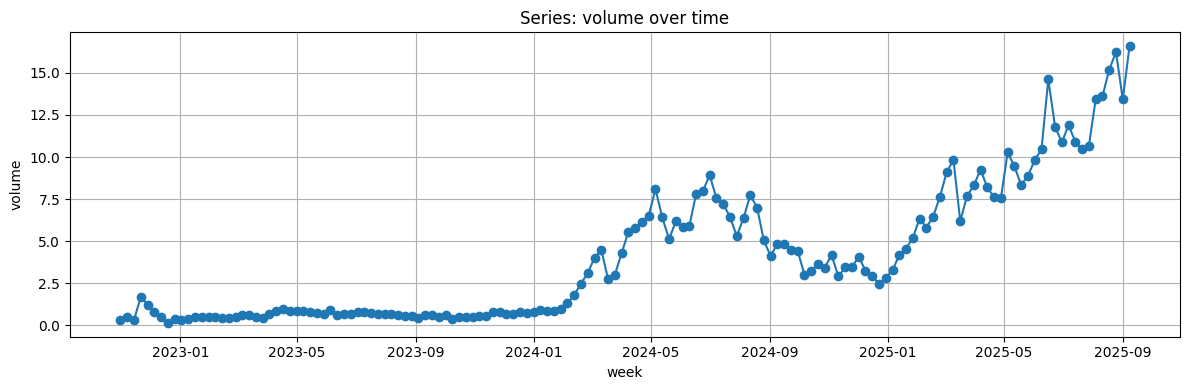

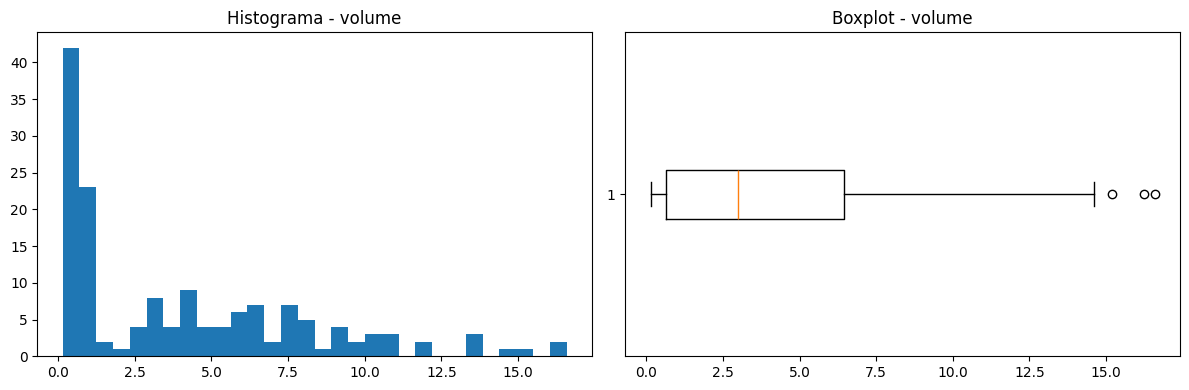

In [9]:
# Análise exploratória

plt.figure(figsize=(12,4))
plt.plot(series, marker='o', linestyle='-')
plt.title('Series: volume over time')
plt.ylabel('volume')
plt.xlabel('week')
plt.grid(True)
plt.tight_layout()
plt.show()

# histograma e boxplot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(series.dropna(), bins=30)
plt.title('Histograma - volume')
plt.subplot(1,2,2)
plt.boxplot(series.dropna(), vert=False)
plt.title('Boxplot - volume')
plt.tight_layout()
plt.show()


In [10]:
print("Intervalo dos dados:", series.min(),",", series.max())
print(len(series[series < 1]), "valores menores que 1", )

Intervalo dos dados: 0.14 , 16.59
64 valores menores que 1


# Modelos Baseline

<!-- Introdução -->
Modelos baseline são modelos de previsão simples e fáceis de implementar que servem como um ponto de partida e **referência** para avaliar o desempenho de modelos mais complexos.

Eles são importantes porque:

1.  **Fornecem um ponto de comparação:** Se um modelo sofisticado não consegue superar um baseline simples (como a previsão ingênua), isso sugere que o modelo complexo não está capturando bem os padrões da série, ou que a série é inerentemente difícil de prever.
2.  **São fáceis de entender e comunicar:** Seus resultados são intuitivos e fáceis de explicar para não especialistas.
3.  **Ajudam a identificar a dificuldade do problema:** Um baseline com erro muito alto indica que a série é volátil e difícil de prever com métodos simples.
4.  **Garantem que o modelo complexo agrega valor:** Ao comparar as métricas de erro (MAE, RMSE, MAPE) dos seus modelos de regressão ou SARIMA com as dos baselines, você pode quantificar o quanto seus modelos mais avançados realmente melhoram a previsão.

Nesta seção, implementaremos e avaliaremos alguns baselines comuns para ter essa referência inicial de desempenho.

In [11]:
# Split treino/teste
train, test = train_test_split_ts(series.to_frame(), test_size=0.2)
train_s = train['volume']
test_s = test['volume']
print(f"\nTreino: {len(train_s)} obs, Teste: {len(test_s)} obs")


Treino: 120 obs, Teste: 30 obs


In [12]:
# Pré-configuração para os modelos de baseline

# Lista para armazenar os resultados da avaliação de todos os baselines
base_eval = []

# Parâmetro para o Rolling Mean (número de períodos a serem considerados)
K = 4

### Método da Média (Mean Method)

Este método assume que a melhor previsão para o futuro é simplesmente a média dos valores históricos observados até o momento. A previsão para $h$ períodos à frente ($T+h$) é dada por:

$\hat{y}_{T+h|T} = \bar{y} = \frac{y_1 + ... + y_T}{T}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $\bar{y}$ é a média dos valores observados até o tempo $T$.
- $y_i$ é o valor observado no tempo $i$.
- $T$ é o número total de observações históricas.

Este método é eficaz quando a série temporal não apresenta uma tendência clara ou sazonalidade, e os valores futuros são esperados em torno da média histórica. É o baseline mais simples e serve para verificar se qualquer modelo mais complexo consegue superar a simples média histórica.

Mean Method Results:
  MAE: 7.9639
  RMSE: 8.4335
  MAPE: 74.2527%


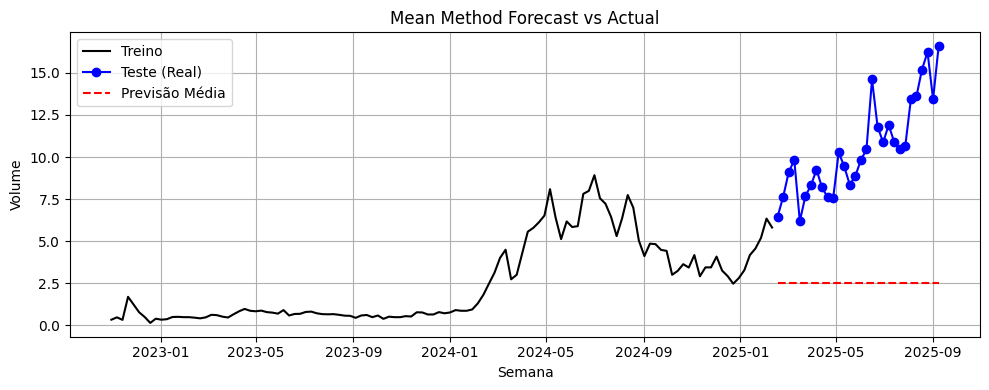

In [13]:
# Mean Method: predição = média de todo o treino

# Calcular a previsão (a média do treino repetida para o tamanho do teste)
mean_pred = np.repeat(train_s.mean(), len(test_s))

# Avaliar o baseline da Média
mean_mae = mean_absolute_error(test_s, mean_pred)
mean_rmse = rmse(test_s, mean_pred)
mean_mape = mape(test_s, mean_pred)

# Armazenar os resultados
base_eval.append({'model': 'Mean', 'MAE': mean_mae, 'RMSE': mean_rmse, 'MAPE': mean_mape})

# Exibir os resultados para este baseline
print('Mean Method Results:')
print(f'  MAE: {mean_mae:.4f}')
print(f'  RMSE: {mean_rmse:.4f}')
print(f'  MAPE: {mean_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, mean_pred, label='Previsão Média', color='red', linestyle='--')
plt.title('Mean Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Método Ingênuo ou Passeio Aleatório sem Tendência (Naive or Random Walk with No Drift)

Neste método, a previsão para o próximo período é simplesmente o último valor observado. Este método é conhecido como “ingênuo” porque assume que as mudanças futuras serão iguais às últimas observações, ou seja, que não temos nenhum insight sistemático sobre os valores futuros além do valor mais recente. A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_T$ é o último valor observado no tempo $T$.

Este baseline é muito útil para séries que se assemelham a um passeio aleatório. Se um modelo não consegue superar o método ingênuo, isso pode indicar que a série é muito volátil ou que o modelo não está capturando adequadamente a estrutura de dependência temporal de curto prazo.

Naive Method Results:
  MAE: 4.6803
  RMSE: 5.4411
  MAPE: 40.7889%


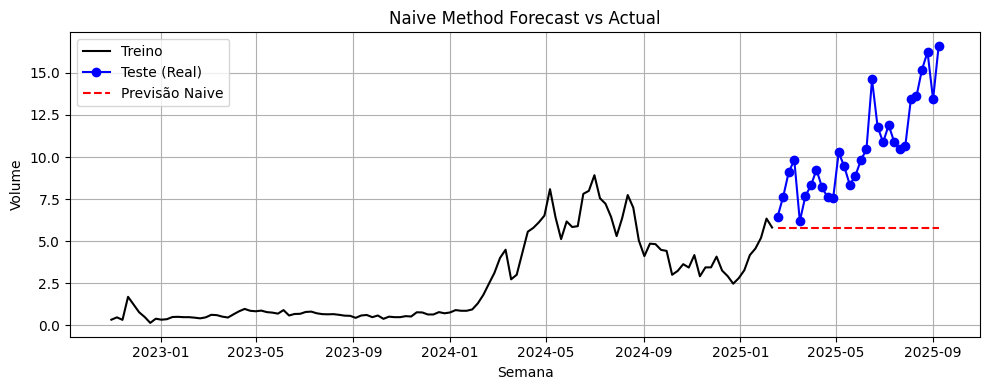

In [14]:
# Naive forecast: predição = último valor do treino

# Calcular a previsão (o último valor do treino repetido para o tamanho do teste)
naive_pred = np.repeat(train_s.iloc[-1], len(test_s))

# Avaliar o baseline Naive
naive_mae = mean_absolute_error(test_s, naive_pred)
naive_rmse = rmse(test_s, naive_pred)
naive_mape = mape(test_s, naive_pred)

# Armazenar os resultados
base_eval.append({'model': 'Naive', 'MAE': naive_mae, 'RMSE': naive_rmse, 'MAPE': naive_mape})

# Exibir os resultados para este baseline
print('Naive Method Results:')
print(f'  MAE: {naive_mae:.4f}')
print(f'  RMSE: {naive_rmse:.4f}')
print(f'  MAPE: {naive_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, naive_pred, label='Previsão Naive', color='red', linestyle='--')
plt.title('Naive Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Método Sazonal Ingênuo (Seasonal Naive)

Este método é uma variação do método ingênuo, especialmente útil para séries com forte sazonalidade conhecida. Ele prevê o valor para um período futuro usando o valor observado no mesmo período sazonal do ciclo anterior.

A previsão para o período $T+h$ é dada por:

$\hat{y}_{T+h|T} = y_{T+h-m}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_{T+h-m}$ é o valor observado no mesmo período sazonal ($m$) do ciclo anterior mais recente disponível nos dados históricos.
- $m$ é o período da sazonalidade (por exemplo, $m=12$ para dados mensais com sazonalidade anual, $m=52$ para dados semanais com sazonalidade anual).

Este baseline é um forte concorrente para séries com padrões sazonais consistentes. Se um modelo não superar o Seasonal Naive para uma série sazonal, ele pode não estar capturando bem o componente sazonal.

Seasonal Naive Method Results:
  MAE: 4.7593
  RMSE: 5.4027
  MAPE: 44.0100%


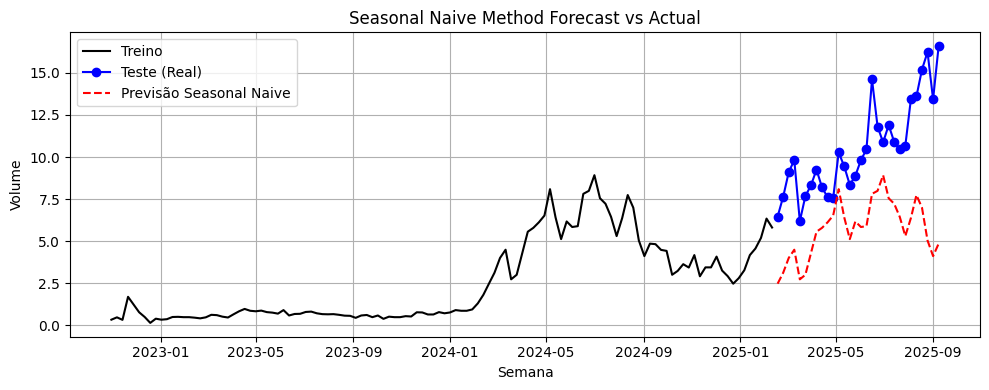

In [15]:
# Seasonal Naive: predição = valor de t-period

# Calcular a previsão sazonal ingênua
seasonal_naive_pred = []
SEASONAL_PERIOD = 52
if len(train_s) >= SEASONAL_PERIOD:
    for idx in test_s.index:
        # usar valor do mesmo periodo (periodo semanas) do último ano
        try:
            seasonal_naive_pred.append(train_s.loc[idx - pd.DateOffset(weeks=SEASONAL_PERIOD)])
        except Exception:
            # fallback: usar valor da posição -period relativa ao fim do treino
            # Isso só aconteceria se o período de teste fosse muito grande
            # e extrapolasse os dados de treino disponíveis para o ciclo sazonal anterior.
            # Para test_size < SEASONAL_PERIOD, o try deve funcionar.
            print(f"Warning: Fallback used for index {idx}")
            seasonal_naive_pred.append(train_s.iloc[-SEASONAL_PERIOD + (len(seasonal_naive_pred) % SEASONAL_PERIOD)])
    seasonal_naive_pred = np.array(seasonal_naive_pred)

    # Avaliar o baseline Seasonal Naive
    seasonal_naive_mae = mean_absolute_error(test_s, seasonal_naive_pred)
    seasonal_naive_rmse = rmse(test_s, seasonal_naive_pred)
    seasonal_naive_mape = mape(test_s, seasonal_naive_pred)

    # Armazenar os resultados
    base_eval.append({'model': 'SeasonalNaive', 'MAE': seasonal_naive_mae, 'RMSE': seasonal_naive_rmse, 'MAPE': seasonal_naive_mape})

    # Exibir os resultados para este baseline
    print('Seasonal Naive Method Results:')
    print(f'  MAE: {seasonal_naive_mae:.4f}')
    print(f'  RMSE: {seasonal_naive_rmse:.4f}')
    print(f'  MAPE: {seasonal_naive_mape:.4f}%')

    plt.figure(figsize=(10, 4))
    plt.plot(train_s.index, train_s, label='Treino', color='black')
    plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
    # Usar o índice do teste para a previsão sazonal, garantindo alinhamento temporal
    plt.plot(test_s.index, seasonal_naive_pred, label='Previsão Seasonal Naive', color='red', linestyle='--')
    plt.title('Seasonal Naive Method Forecast vs Actual')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print(f"Não é possível calcular o Seasonal Naive. Tamanho do treino ({len(train_s)}) é menor que o período sazonal ({SEASONAL_PERIOD}).")

Método do Desvio (Drift Method)
O método do desvio é utilizado para séries temporais que seguem uma tendência linear ao
longo do tempo. Este método assume que a diferença entre observações consecutivas é
constante, resultando em uma previsão que extrapola essa tendência:
yt = C + yt−1 + εt
A previsão para h períodos à frente é dada por:
^yT +h|T = yT + h ⋅ C
Onde C representa o desvio médio entre as observações:
C = ∑T
t=2(yt − yt−1)
T − 1 = yT − y1
T − 1
Portanto, a previsão pode ser reescrita como:
^yT +h|T = yT + h ( yT − y1
T − 1 )
Este método é útil para séries que apresentam uma tendência consistente ao longo do tempo,
como crescimento linear.

### Método do Desvio (Drift Method)

O método do desvio é utilizado para séries temporais que seguem uma tendência linear ao longo do tempo. Este método assume que a diferença média entre observações consecutivas é constante, resultando em uma previsão que extrapola essa tendência:

$y_t = C + y_{t−1} + \epsilon_t$

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T + h \cdot C$

Onde $C$ representa o desvio médio entre as observações no período de treino:

$C = \frac{\sum_{t=2}^T (y_t − y_{t−1})}{T − 1} = \frac{y_T − y_1}{T − 1}$

Portanto, a previsão pode ser reescrita como:

$\hat{y}_{T+h|T} = y_T + h \left( \frac{y_T − y_1}{T − 1} \right)$

Este método é útil para séries que apresentam uma tendência consistente ao longo do tempo, como crescimento linear. Ele é mais robusto que o Método Ingênuo para séries com tendência, pois incorpora essa inclinação média na previsão.

Drift Method Results:
  MAE: 3.9666
  RMSE: 4.6585
  MAPE: 34.3968%


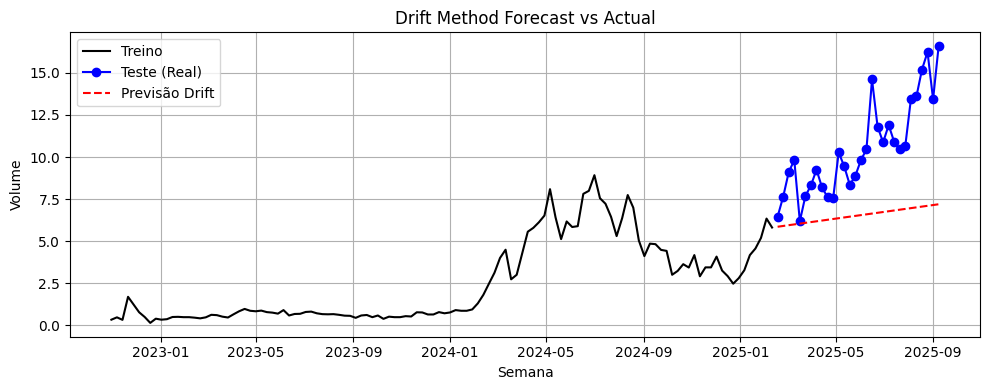

In [16]:
# Drift Method: predição = último valor + h * desvio médio

# Calcular o desvio médio no conjunto de treino
# Desvio = (último valor do treino - primeiro valor do treino) / (Tamanho do treino - 1)
if len(train_s) > 1:
    drift = (train_s.iloc[-1] - train_s.iloc[0]) / (len(train_s) - 1)
else:
    # Se o treino tem apenas 1 ponto, o desvio é 0
    drift = 0
    print("Warning: Cannot calculate drift with only one training point. Drift set to 0.")


# Calcular a previsão para cada passo no conjunto de teste
# Previsão para h passos à frente = último valor do treino + h * drift
drift_pred = []
last_train_value = train_s.iloc[-1]
for h in range(1, len(test_s) + 1):
    drift_pred.append(last_train_value + h * drift)
drift_pred = np.array(drift_pred)


# Avaliar o baseline Drift Method
drift_mae = mean_absolute_error(test_s, drift_pred)
drift_rmse = rmse(test_s, drift_pred)
drift_mape = mape(test_s, drift_pred)

# Armazenar os resultados
base_eval.append({'model': 'Drift', 'MAE': drift_mae, 'RMSE': drift_rmse, 'MAPE': drift_mape})

# Exibir os resultados para este baseline
print('Drift Method Results:')
print(f'  MAE: {drift_mae:.4f}')
print(f'  RMSE: {drift_rmse:.4f}')
print(f'  MAPE: {drift_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
# Usar o índice do teste para a previsão Drift, garantindo alinhamento temporal
plt.plot(test_s.index, drift_pred, label='Previsão Drift', color='red', linestyle='--')
plt.title('Drift Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Método da Média Móvel (Rolling Mean)

O método da média móvel utiliza a média dos últimos $K$ valores observados como previsão para o futuro. Ele suaviza as flutuações de curto prazo e pode capturar tendências locais, mas não lida bem com sazonalidade forte ou tendências de longo prazo.

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = \frac{y_{T} + y_{T-1} + ... + y_{T-K+1}}{K}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_i$ são os valores observados.
- $K$ é o número de períodos usados para calcular a média móvel.

Este baseline é mais reativo a mudanças recentes na série do que o Método da Média simples. O parâmetro $K$ pode ser ajustado; um $K$ menor torna a previsão mais responsiva a mudanças recentes, enquanto um $K$ maior a torna mais suave.

Rolling Mean (k=4) Method Results:
  MAE: 5.0153
  RMSE: 5.7318
  MAPE: 44.2030%


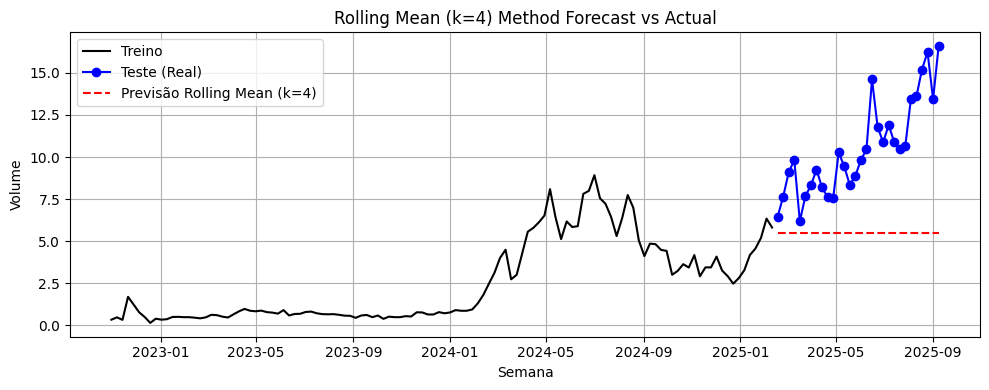

In [17]:
# Rolling mean (últimos k)

# Calcular a previsão (média dos últimos K valores do treino repetida para o tamanho do teste)
# K é definido na célula de pré-configuração.
rolling_mean_pred = np.repeat(train_s.tail(K).mean(), len(test_s))

# Avaliar o baseline Rolling Mean
rolling_mean_mae = mean_absolute_error(test_s, rolling_mean_pred)
rolling_mean_rmse = rmse(test_s, rolling_mean_pred)
rolling_mean_mape = mape(test_s, rolling_mean_pred)

# Armazenar os resultados
base_eval.append({'model': f'RollingMean_k{K}', 'MAE': rolling_mean_mae, 'RMSE': rolling_mean_rmse, 'MAPE': rolling_mean_mape})

# Exibir os resultados para este baseline
print(f'Rolling Mean (k={K}) Method Results:')
print(f'  MAE: {rolling_mean_mae:.4f}')
print(f'  RMSE: {rolling_mean_rmse:.4f}')
print(f'  MAPE: {rolling_mean_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, rolling_mean_pred, label=f'Previsão Rolling Mean (k={K})', color='red', linestyle='--')
plt.title(f'Rolling Mean (k={K}) Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Comparativo final de todos os baselines

# Converter a lista de resultados em um DataFrame pandas
base_eval_df = pd.DataFrame(base_eval)

base_eval_df_sorted = base_eval_df.sort_values(by='RMSE').reset_index(drop=True)

print('\nComparativo de Modelos Baseline:')
display(base_eval_df_sorted)


Comparativo de Modelos Baseline:


,model,MAE,RMSE,MAPE
0,Drift,3.966552,4.658450,34.396808
1,SeasonalNaive,4.759333,5.402674,44.010046
2,Naive,4.680333,5.441076,40.788894
3,RollingMean_k4,5.015333,5.731784,44.202960
4,Mean,7.963917,8.433490,74.252681


## Regressão linear múltipla

# Resumo dos Modelos de Regressão

Análise completa de séries temporais, incluindo regressão linear múltipla e modelos SARIMAX, com diagnóstico de resíduos e comparação de desempenho.

---

## 1. Regressão Linear Múltipla (OLS)

### Estrutura do modelo
- **Variável dependente:** `volume` (série temporal)
- **Preditores utilizados:**
  - `t` → tendência linear ao longo do tempo
  - Harmônicos sazonais:
    - `sin1`, `cos1` → 1º harmônico (captura sazonalidade básica)
    - `sin2`, `cos2` → 2º harmônico (captura sazonalidade mais complexa)
  - Dummies de mês (`m_2`, ..., `m_12`) → capturam efeito fixo mensal
- **Intercepto** adicionado automaticamente pelo `sm.add_constant()`

### Objetivo
- Ajustar um modelo de regressão que capture **tendência + sazonalidade** de forma interpretável.

### Diagnóstico de resíduos
- **ACF/PACF:** Verifica autocorrelação nos resíduos → idealmente devem ser ruído branco.
- **Histograma:** Avalia normalidade aproximada.
- **QQ-Plot:** Comparação com distribuição normal.
- **Teste de Ljung-Box:** Detecta autocorrelação residual significativa.
- **Resultados:** Resíduos podem indicar necessidade de incluir lags ou migrar para SARIMAX.

### Treino/Teste
- Conjunto de treino: 80% inicial da série.
- Conjunto de teste: últimas 12 semanas (`TEST_SIZE`).
- Métricas de performance no teste:
  - **RMSE**
  - **MAPE**
- Previsões geradas tanto para treino quanto para teste.

---

## 2. Modelos SARIMAX

### Estrutura
- Modelos ARIMA/SARIMA para capturar:
  - Autoregressão (AR)
  - Diferença (I)
  - Média móvel (MA)
  - Sazonalidade (P,D,Q,m)
- Ajuste via:
  - `pmdarima.auto_arima()` se disponível (automático)
  - Grid search conservador manual com `statsmodels.SARIMAX`

### Objetivo
- Capturar dependências temporais que OLS não consegue modelar, incluindo sazonalidade e autocorrelação nos resíduos.

### Diagnóstico de resíduos
- Mesmos gráficos do OLS:
  - ACF/PACF
  - Histograma
  - QQ-Plot
  - Ljung-Box
- Permite avaliar qualidade do ajuste SARIMAX.

### Forecasting
- Previsão das últimas 12 semanas.
- Métricas de performance:
  - **RMSE**
  - **MAPE**
- Comparação direta com o modelo de regressão.

---

## 3. Comparação de Modelos

| Modelo                                      | AIC   | BIC   | RMSE  | MAPE  |
|--------------------------------------------|-------|-------|-------|-------|
| Regressão (tendência + harmônicos + mês)   | -     | -     | X.XXXX| X.XXXX|
| Melhor SARIMAX                              | XX.XX | XX.XX | X.XXXX| X.XXXX|

> **Observações:**
> - AIC/BIC só são computados para modelos SARIMAX.
> - OLS é avaliado por RMSE/MAPE no conjunto de teste.

---

## 4. Saída do Script

- **Relatórios e plots gerados:**
  - `ols_summary.txt` → resumo do modelo OLS
  - `ols_resid_acf.png`, `ols_resid_pacf.png`, `ols_resid_hist.png`, `ols_resid_qq.png`
  - `ols_ljungbox.csv` → teste de Ljung-Box
  - `sarimax_summaries.txt` → top SARIMAX models
  - `sarimax_resid_*` → gráficos de diagnóstico SARIMAX
  - `sarimax_ljungbox.csv`
  - `model_predictions_comparison.csv` → comparação de previsões OLS vs SARIMAX
  - `model_comparison.csv` → métricas finais
  - `readme_results.txt` → resumo legível dos resultados

---

**Conclusão:**
- O script combina **modelos de regressão interpretáveis** (tendência + harmônicos + dummies) com **modelos SARIMAX robustos** para capturar dependência temporal e sazonalidade.  
- Permite **diagnóstico completo** e **comparação de performance**, salvando todas as informações para análise posterior.


In [19]:
"""
Análise completa de séries temporais com:
 - Regressão linear múltipla (tendência + harmônicos sazonais + dummies de mês)
 - Modelos ARIMA/SARIMA (statsmodels; opcional: pmdarima.auto_arima)
 - Resultados para diagnóstico de resíduos (ACF/PACF, Ljung-Box, histograma, QQplot)
 - Comparação por AIC/BIC/RMSE/MAPE
 - Exportação de resultados e plots

Salva resultados em ./results_linear_regression/
"""

import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Configurações gerais
# -------------------------
OUTDIR = Path("./results_linear_regression")
OUTDIR.mkdir(parents=True, exist_ok=True)

data_csv = "data.csv"
# data_csv = """week,volume
#               2022-10-31,0.33
#               ...
#            """

INPUT_CSV_PATH = Path("data.csv")  # usado se data_csv for None

# Parâmetros de modelagem
SEASONAL_PERIOD = 52        # sazonalidade anual em semanas (~52, uma ano)
TEST_SIZE = 12              # número de semanas no conjunto de teste para validação
SARIMAX_GRID_SMALL = {
    "p": [0, 1, 2],
    "d": [0, 1],
    "q": [0, 1],
    "P": [0, 1],
    "D": [0, 1],
    "Q": [0, 1],
}


In [20]:
# -------------------------
# Funções utilitárias
# -------------------------
INPUT_CSV_PATH = "data.csv"  # caminho do arquivo local

def load_data():
    """Carrega os dados do CSV (arquivo) e prepara a série temporal."""
    df = pd.read_csv(INPUT_CSV_PATH, parse_dates=["week"])
    df = df.sort_values("week").reset_index(drop=True)
    df = df.set_index("week")
    df.index = pd.to_datetime(df.index)

    # Garantir numérico
    df["volume"] = pd.to_numeric(df["volume"], errors="coerce")

    # Interpolar eventuais gaps (caso haja)
    df["volume"] = df["volume"].interpolate()

    return df



def evaluate(y_true, y_pred, model=None):
    """Calcula métricas de avaliação."""
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results = {"rmse": float(rmse), "mape": float(mape), "r2": float(r2)}

    if model is not None:
        results["r2_adj"] = float(model.rsquared_adj)
        results["std_err_reg"] = float(model.mse_resid ** 0.5)

    return results



In [21]:
# -------------------------
# Carregamento e features
# -------------------------
df = load_data()
df.to_csv(OUTDIR / "data_used.csv") # ordena por data, interpola se tiver valores faltantes.

data = df.reset_index()
T = len(data)
data["t"] = np.arange(1, T + 1)  # tendência (linear) , que cresce de 1 até T, para capturar crescimento/queda ao longo do tempo.

# Harmônicos para sazonalidade (1º e 2º harmônicos)
data["sin1"] = np.sin(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos1"] = np.cos(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["sin2"] = np.sin(4 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos2"] = np.cos(4 * np.pi * data["t"] / SEASONAL_PERIOD)

# Dummies para mês (poderia ser semana do ano, dia da semana, etc.)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True)
data = pd.concat([data, month_dummies], axis=1)
# print(data)

# Preditores para regressão
predictors = ["t", "sin1", "cos1", "sin2", "cos2"] + list(month_dummies.columns) # variáveis explicativas.
X_all = sm.add_constant(data[predictors]) # adiciona a constante (intercepto) ao modelo.
y_all = data["volume"] # variável resposta (a série volume).


# Criar preditores
t = np.arange(len(data))
X_all = pd.DataFrame({"t": t})
for k in range(1, 3):
    X_all[f"sin{k}"] = np.sin(2*np.pi*k*t/SEASONAL_PERIOD)
    X_all[f"cos{k}"] = np.cos(2*np.pi*k*t/SEASONAL_PERIOD)

# Dummies de mês (converter direto para float)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True).astype(float)

X_all = pd.concat([X_all, month_dummies], axis=1)
X_all = sm.add_constant(X_all).astype(float)

y_all = data["volume"].astype(float)


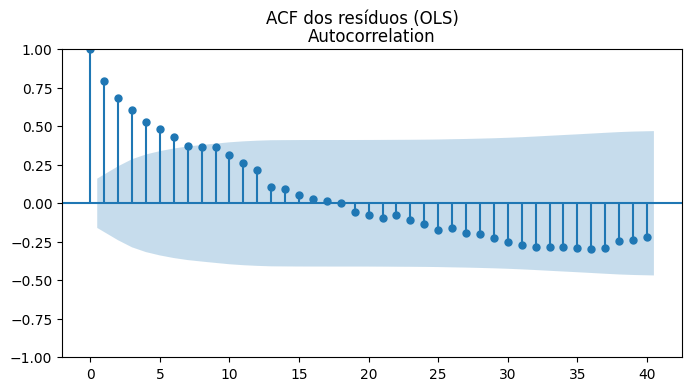

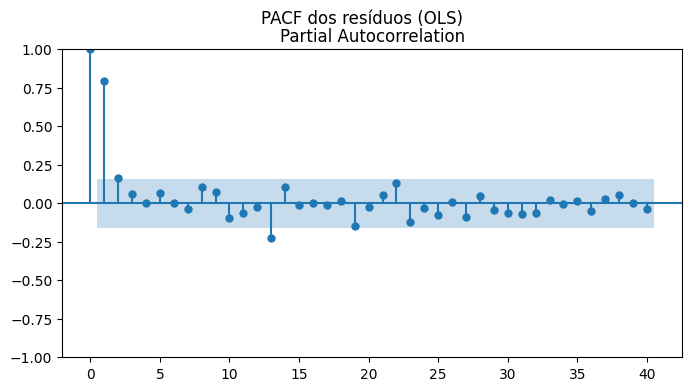

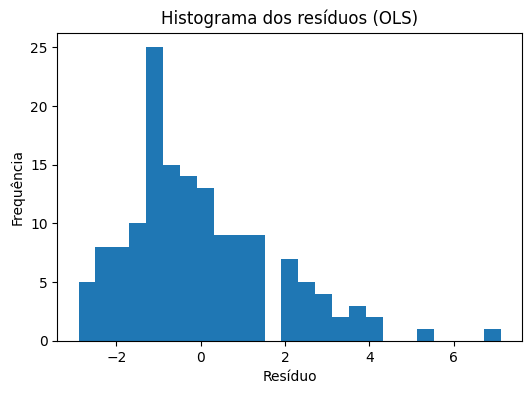

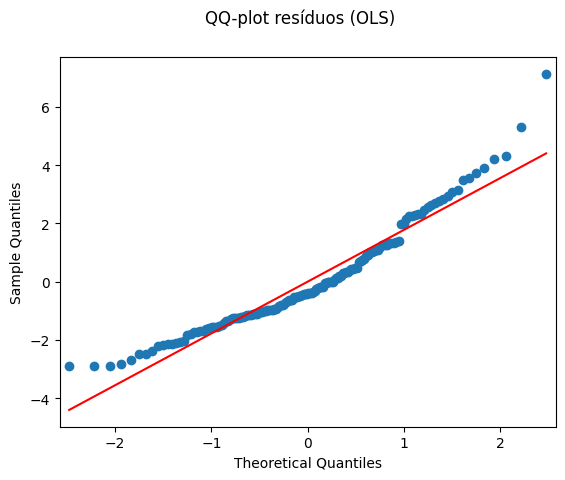

In [22]:
# -------------------------
# Regressão OLS (full sample)
# -------------------------

#Ajuste do modelo OLS (Mínimos Quadrados Ordinários)
ols_full = sm.OLS(y_all, X_all).fit() #estima os coeficientes que minimizam a soma dos erros quadrados.
(OUTDIR / "ols_summary.txt").write_text(ols_full.summary().as_text()) # gera estatísticas do modelo (coeficientes, R², p-values, etc.)

# Residual diagnostics (OLS)

#vetor de resíduos. São usados para avaliar se o modelo capturou bem a estrutura da série.
resid = ols_full.resid

# ACF (Autocorrelation Function): mede se os resíduos estão correlacionados ao longo do tempo.
# Idealmente, resíduos devem ser ruído branco → sem autocorrelação significativa.
# Se houver autocorrelação, significa que o modelo não capturou toda a dependência temporal.
fig = plt.figure(figsize=(8,4))
plot_acf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF dos resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_acf.png")
plt.show()
plt.close(fig)

# PACF (Partial Autocorrelation Function): mostra a autocorrelação de uma defasagem, condicionada às defasagens anteriores.
# Ajuda a detectar se ainda existe estrutura AR (autoregressiva) nos resíduos.
fig = plt.figure(figsize=(8,4))
plot_pacf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF dos resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_pacf.png")
plt.show()
plt.close(fig)

# Histograma dos resíduos
# Verifica se os resíduos seguem uma distribuição aproximadamente normal (hipótese da regressão linear).
# Se houver caudas pesadas ou assimetria, pode indicar problemas no ajuste.
fig = plt.figure(figsize=(6,4))
plt.hist(resid, bins=25)
plt.title("Histograma dos resíduos (OLS)")
plt.xlabel("Resíduo"); plt.ylabel("Frequência")
fig.savefig(OUTDIR / "ols_resid_hist.png")
plt.show()
plt.close(fig)

# QQ-plot (Quantile-Quantile)
# Compara os quantis dos resíduos com os quantis de uma distribuição normal.
# Se os pontos seguirem a linha → resíduos são aproximadamente normais.
# Se houver desvios nas caudas → problemas de heterocedasticidade ou não-normalidade.
fig = qqplot(resid, line="s")
fig.suptitle("QQ-plot resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_qq.png")
plt.show()
plt.close(fig)

# Teste de Ljung-Box
lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
lb.to_csv(OUTDIR / "ols_ljungbox.csv")


In [23]:
# -------------------------
# Treino / Teste (para comparar previsões)
# -------------------------

train = data.iloc[:-TEST_SIZE].copy()
test = data.iloc[-TEST_SIZE:].copy()

y_train = train["volume"]
y_test = test["volume"]

X_train = sm.add_constant(train[predictors])
X_test = sm.add_constant(test[predictors])

y_train = pd.to_numeric(y_train, errors="coerce").astype(float)
y_test = pd.to_numeric(y_test, errors="coerce").astype(float)

X_train = X_train.apply(pd.to_numeric, errors="coerce").astype(float)
X_test = X_test.apply(pd.to_numeric, errors="coerce").astype(float)



ols_train = sm.OLS(y_train, X_train).fit()
reg_pred = ols_train.predict(X_test)
reg_metrics = evaluate(y_test, reg_pred)

pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_true": y_test.values,
    "reg_pred": reg_pred.values
})


In [24]:
# -------------------------
# SARIMAX modeling
# - Tenta usar pmdarima.auto_arima se disponível (mais prático)
# - Se não, faz um grid search pequeno com statsmodels.SARIMAX
# -------------------------
use_auto = False
try:
    import pmdarima as pm
    use_auto = True
except Exception:
    use_auto = False

sarimax_results = []
if use_auto:
    # auto_arima (rápido se stepwise; precisa de pmdarima instalado)
    auto = pm.auto_arima(y_train, seasonal=True, m=SEASONAL_PERIOD,
                         stepwise=True, suppress_warnings=True, error_action="ignore")
    order = auto.order
    seasonal_order = auto.seasonal_order
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    sarimax_results.append({"model": f"AUTO ({order}) x {seasonal_order}", "aic": res.aic, "bic": res.bic, "res": res})
else:
    # Grid search conservador (ajuste os ranges em SARIMAX_GRID_SMALL para explorar mais)
    p_range = SARIMAX_GRID_SMALL["p"]
    d_range = SARIMAX_GRID_SMALL["d"]
    q_range = SARIMAX_GRID_SMALL["q"]
    P_range = SARIMAX_GRID_SMALL["P"]
    D_range = SARIMAX_GRID_SMALL["D"]
    Q_range = SARIMAX_GRID_SMALL["Q"]
    m = SEASONAL_PERIOD

    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            try:
                                mod = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                                              enforce_stationarity=False, enforce_invertibility=False)
                                res = mod.fit(disp=False, low_memory=True)
                                sarimax_results.append({
                                    "model": f"SARIMAX ({p},{d},{q}) x ({P},{D},{Q},{m})",
                                    "aic": res.aic, "bic": res.bic, "res": res
                                })
                            except Exception as e:
                                # falhas de convergência são normais em grid search; ignoramos
                                continue

# Se não houve modelos (por falha), interrompa
if len(sarimax_results) == 0:
    raise RuntimeError("Não foi possível ajustar nenhum modelo SARIMAX. Tente ajustar ranges menores ou instalar pmdarima.")

# Ordena por AIC e guarda top models
sarimax_results = sorted(sarimax_results, key=lambda x: x["aic"])
top_results = sarimax_results[:5]
# salva summaries
summaries_txt = ""
for i, item in enumerate(top_results):
    summaries_txt += f"Model {i+1}: {item['model']}  AIC={item['aic']:.2f}  BIC={item['bic']:.2f}\n"
    summaries_txt += item["res"].summary().as_text()
    summaries_txt += "\n\n" + ("-"*80) + "\n\n"
(OUTDIR / "sarimax_summaries.txt").write_text(summaries_txt)

# Escolhe o melhor para previsões (top_results[0])
best_res = top_results[0]["res"]

# Forecasting (estático/determinístico): preve as próximas TEST_SIZE semanas
sarimax_forecast_obj = best_res.get_forecast(steps=TEST_SIZE)
sarimax_pred_mean = sarimax_forecast_obj.predicted_mean
# Alinha índices com as semanas reais do conjunto de teste
sarimax_pred_mean.index = test["week"].values

sarimax_metrics = evaluate(y_test, sarimax_pred_mean)

pred_df["sarimax_pred"] = sarimax_pred_mean.values
pred_df.to_csv(OUTDIR / "model_predictions_comparison.csv", index=False)


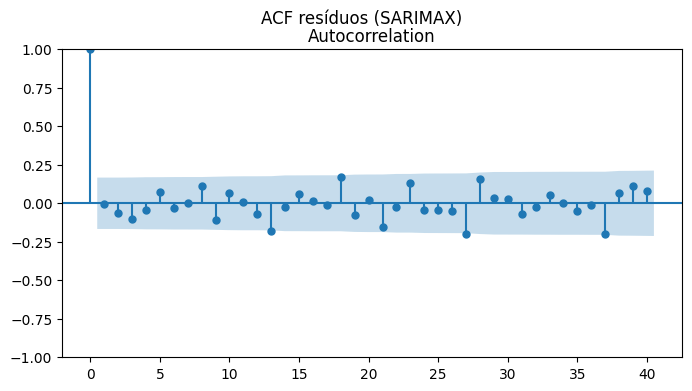

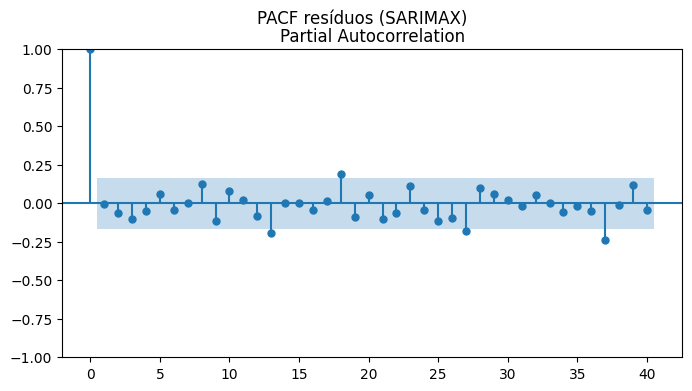

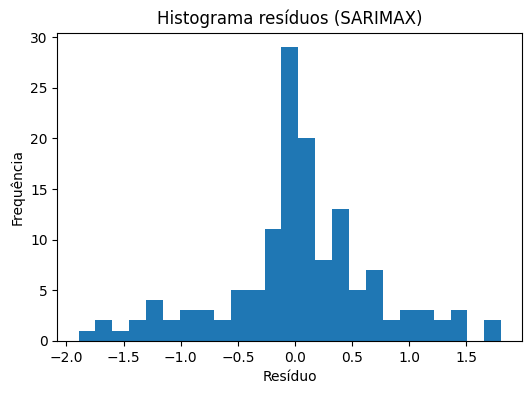

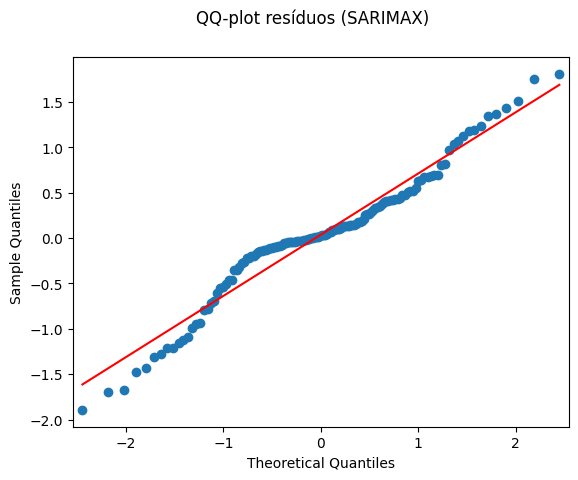

In [25]:

# Residual diagnostics (melhor SARIMAX)
resid_s = best_res.resid
fig = plt.figure(figsize=(8,4))
plot_acf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_acf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(8,4))
plot_pacf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_pacf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(6,4))
plt.hist(resid_s, bins=25)
plt.title("Histograma resíduos (SARIMAX)")
plt.xlabel("Resíduo"); plt.ylabel("Frequência")
fig.savefig(OUTDIR / "sarimax_resid_hist.png")
plt.show()
plt.close(fig)

fig = qqplot(resid_s, line="s")
fig.suptitle("QQ-plot resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_qq.png")
plt.show()
plt.close(fig)

lb_s = acorr_ljungbox(resid_s, lags=[10, 20], return_df=True)
lb_s.to_csv(OUTDIR / "sarimax_ljungbox.csv")




In [26]:
# -------------------------
# Comparação final e salvamento
# -------------------------
comparison = pd.DataFrame([
    {
        "model": "Regression (trend+harmonics+month dummies)",
        "aic": np.nan, "bic": np.nan,
        "rmse": reg_metrics["rmse"], "mape": reg_metrics["mape"]
    },
    {
        "model": top_results[0]["model"],
        "aic": top_results[0]["aic"], "bic": top_results[0]["bic"],
        "rmse": sarimax_metrics["rmse"], "mape": sarimax_metrics["mape"]
    }
])
comparison.to_csv(OUTDIR / "model_comparison.csv", index=False)

# Save a short human-readable summary
summary = f"""
Análise completa salva em: {OUTDIR.resolve()}
Regressão (teste último {TEST_SIZE}): RMSE={reg_metrics['rmse']:.4f}, MAPE={reg_metrics['mape']:.4f}
SARIMAX (teste último {TEST_SIZE}): RMSE={sarimax_metrics['rmse']:.4f}, MAPE={sarimax_metrics['mape']:.4f}
Melhor SARIMAX: {top_results[0]['model']} (AIC={top_results[0]['aic']:.2f}, BIC={top_results[0]['bic']:.2f})
"""
(OUTDIR / "readme_results.txt").write_text(summary)
print(summary)

# Lista arquivos gerados
print("Arquivos gerados:")
for p in sorted(OUTDIR.iterdir()):
    print("-", p.name)



Análise completa salva em: C:\Users\dudda\Downloads\time-series\results_linear_regression
Regressão (teste último 12): RMSE=5.1834, MAPE=0.3303
SARIMAX (teste último 12): RMSE=3.2793, MAPE=0.2212
Melhor SARIMAX: SARIMAX (0,1,1) x (0,1,1,52) (AIC=83.05, BIC=87.36)

Arquivos gerados:
- data_used.csv
- forecast_comparison.png
- model_comparison.csv
- model_predictions_comparison.csv
- ols_ljungbox.csv
- ols_resid_acf.png
- ols_resid_hist.png
- ols_resid_pacf.png
- ols_resid_qq.png
- ols_summary.txt
- readme_results.txt
- sarimax_ljungbox.csv
- sarimax_resid_acf.png
- sarimax_resid_hist.png
- sarimax_resid_pacf.png
- sarimax_resid_qq.png
- sarimax_summaries.txt


In [27]:
# garante que 'week' está em datetime
df_check["week"] = pd.to_datetime(df_check["week"])

plt.figure(figsize=(12,6))
plt.plot(df_check["week"], df_check["volume"], marker="o", linestyle="-", color="black")

plt.title("Série Temporal Original - Volume por Semana")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'df_check' is not defined

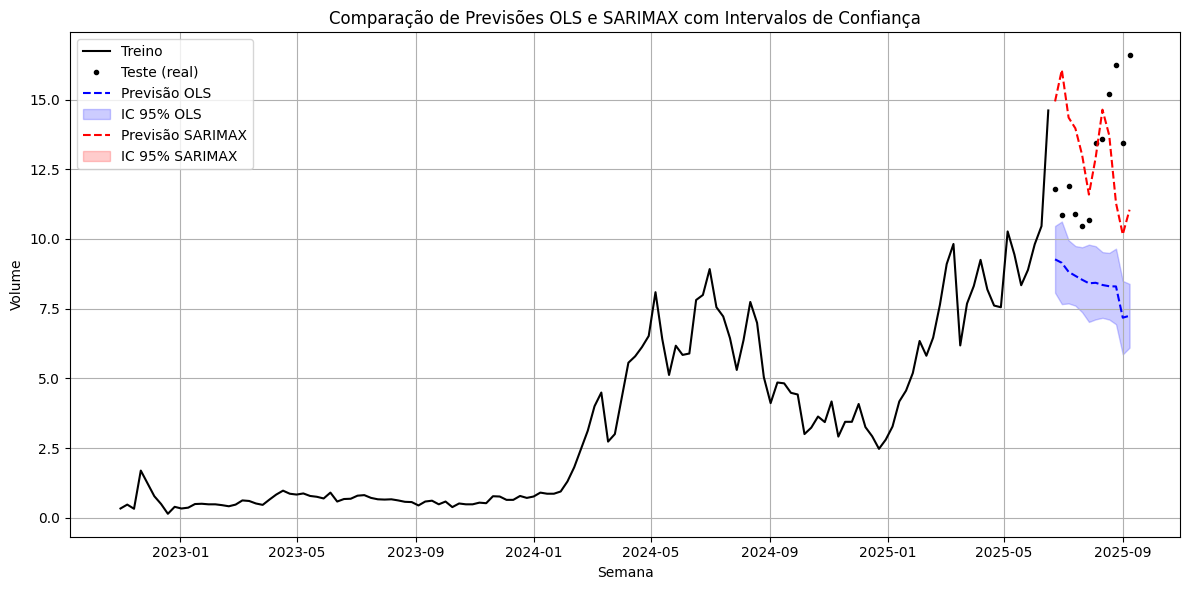

In [28]:
# -------------------------
# Preparar previsões com IC
# -------------------------

# 1️ Previsão OLS
ols_forecast_obj = ols_train.get_prediction(X_test)
ols_pred_mean = ols_forecast_obj.predicted_mean
ols_ci = ols_forecast_obj.conf_int(alpha=0.05)

ols_pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_pred": ols_pred_mean,
    "ci_lower": ols_ci[:, 0],
    "ci_upper": ols_ci[:, 1]
})

# 2️ Previsão SARIMAX
sarimax_forecast_obj = best_res.get_forecast(steps=len(test))
sarimax_forecast_df = sarimax_forecast_obj.summary_frame(alpha=0.05)

# Garantir alinhamento correto com o eixo x
sarimax_pred_df = sarimax_forecast_df.copy()
sarimax_pred_df["week"] = test["week"].values
sarimax_pred_df.rename(columns={
    "mean": "y_pred",
    "mean_ci_lower": "ci_lower",
    "mean_ci_upper": "ci_upper"
}, inplace=True)

# -------------------------
# Plotagem
# -------------------------
plt.figure(figsize=(12,6))

# Treino
plt.plot(train["week"], train["volume"], color="black", linestyle="-", label="Treino")

# Teste (real)
plt.plot(test["week"], test["volume"], color="black", marker=".", linestyle="None", label="Teste (real)")

# OLS
plt.plot(ols_pred_df["week"], ols_pred_df["y_pred"], color="blue", linestyle="--", label="Previsão OLS")
plt.fill_between(ols_pred_df["week"], ols_pred_df["ci_lower"], ols_pred_df["ci_upper"],
                 color="blue", alpha=0.2, label="IC 95% OLS")

# SARIMAX
plt.plot(sarimax_pred_df["week"], sarimax_pred_df["y_pred"], color="red", linestyle="--", label="Previsão SARIMAX")
plt.fill_between(sarimax_pred_df["week"], sarimax_pred_df["ci_lower"], sarimax_pred_df["ci_upper"],
                 color="red", alpha=0.2, label="IC 95% SARIMAX")

# Estilo e labels
plt.title("Comparação de Previsões OLS e SARIMAX com Intervalos de Confiança")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Salvar e mostrar
plt.savefig(OUTDIR / "forecast_comparison.png")
plt.show()
plt.close()


# Análise de resíduos e ajuste dos modelos

In [29]:
# Configurações de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


 EXECUTANDO ANÁLISE DE RESÍDUOS...
 INICIANDO ANÁLISE DE RESÍDUOS...

 VERIFICAÇÃO DE TAMANHOS:
   Mean: 30 previsões
   Naive: 30 previsões
   SeasonalNaive: 30 previsões
   Drift: 30 previsões
   RollingMean_k4: 30 previsões
   Regression: 12 previsões
   SARIMAX: 12 previsões
   Teste: 12 observações
   Treino: 138 observações

################################################################################
ANALISANDO MODELO: Mean
################################################################################
  Ajustando tamanho das previsões para Mean: 30 -> 12
 Tamanhos - Resíduos: 12, Fitted: 12, Actual: 12

ANÁLISE DE RESÍDUOS - Mean
Gráfico salvo em: residuals_analysis\residuals_analysis_mean.png


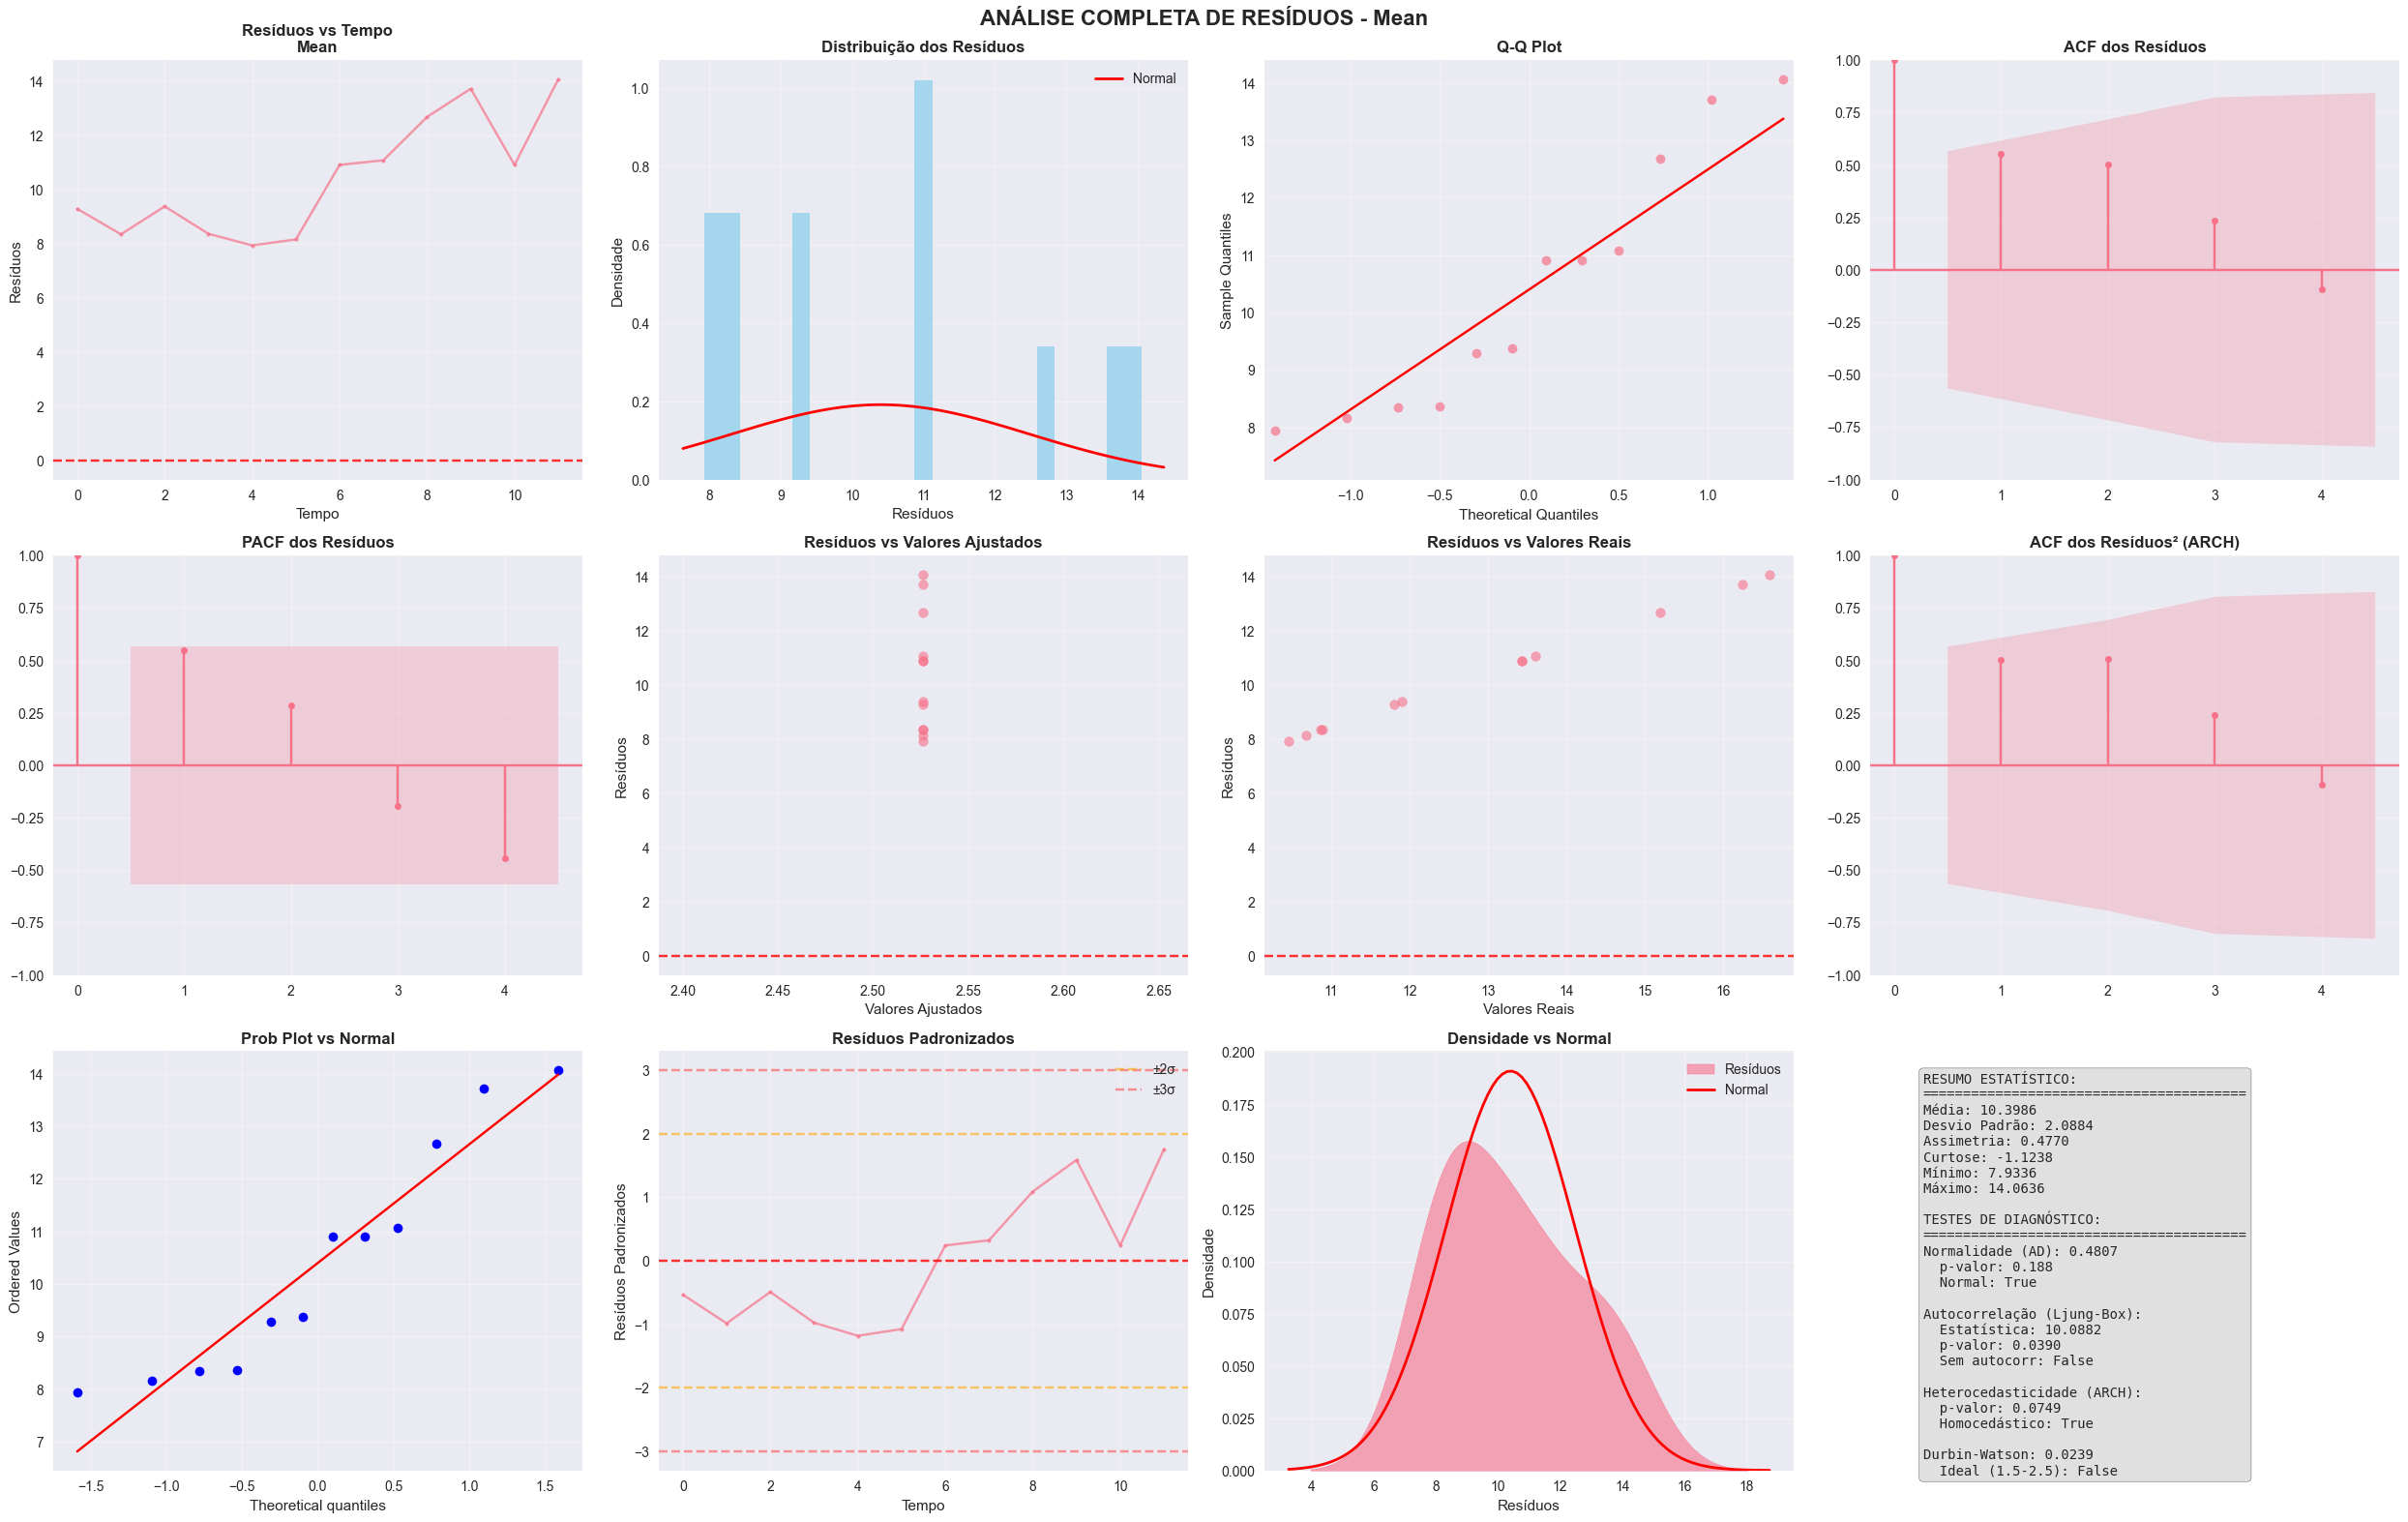


 DIAGNÓSTICO DOS RESÍDUOS:
──────────────────────────────────────────────────
X Média zero
OK Normalidade
X Sem autocorrelação
OK Homocedasticidade
X Durbin-Watson

 ESTATÍSTICAS CHAVE:
   • RMSE dos resíduos: 10.6062
   • MAE dos resíduos: 10.3986
   • Assimetria: 0.4770
   • Curtose: -1.1238

 RECOMENDAÇÕES:
   • Autocorrelação detectada - modelo pode capturar padrões inadequados
   • Autocorrelação positiva - subestimação do erro padrão

################################################################################
ANALISANDO MODELO: Naive
################################################################################
  Ajustando tamanho das previsões para Naive: 30 -> 12
 Tamanhos - Resíduos: 12, Fitted: 12, Actual: 12

ANÁLISE DE RESÍDUOS - Naive
Gráfico salvo em: residuals_analysis\residuals_analysis_naive.png


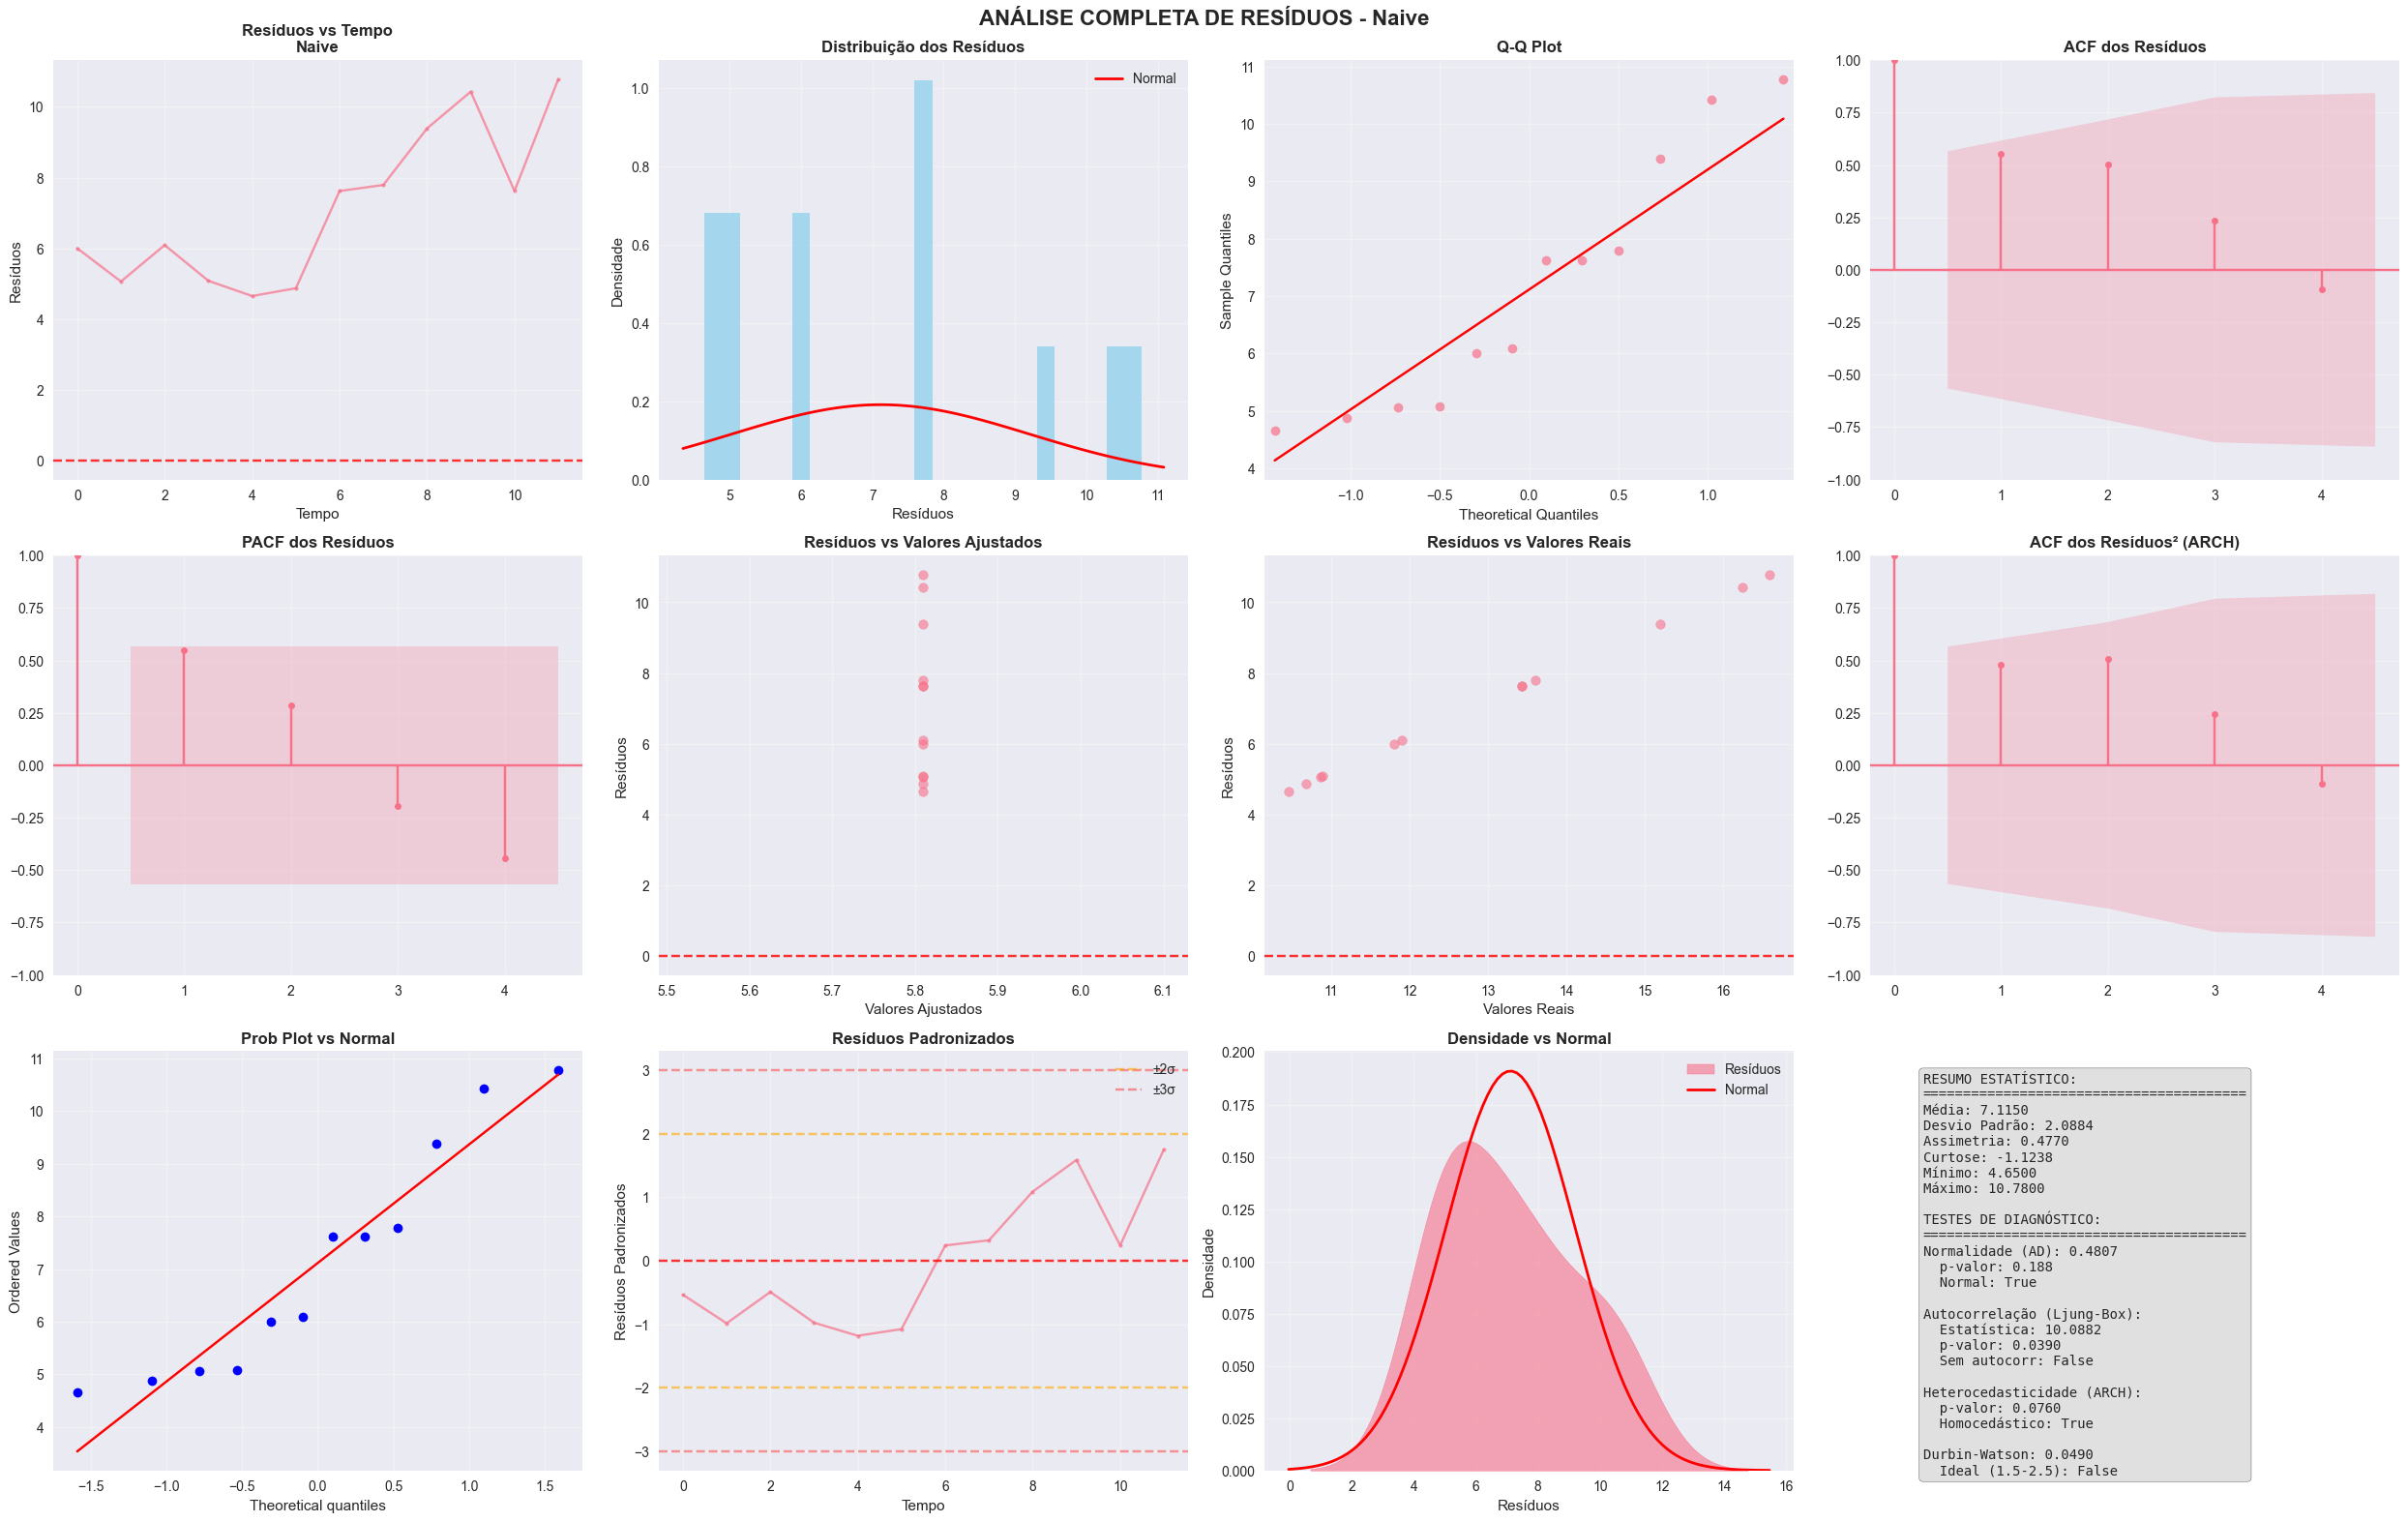


 DIAGNÓSTICO DOS RESÍDUOS:
──────────────────────────────────────────────────
X Média zero
OK Normalidade
X Sem autocorrelação
OK Homocedasticidade
X Durbin-Watson

 ESTATÍSTICAS CHAVE:
   • RMSE dos resíduos: 7.4152
   • MAE dos resíduos: 7.1150
   • Assimetria: 0.4770
   • Curtose: -1.1238

 RECOMENDAÇÕES:
   • Autocorrelação detectada - modelo pode capturar padrões inadequados
   • Autocorrelação positiva - subestimação do erro padrão

################################################################################
ANALISANDO MODELO: SeasonalNaive
################################################################################
  Ajustando tamanho das previsões para SeasonalNaive: 30 -> 12
 Tamanhos - Resíduos: 12, Fitted: 12, Actual: 12

ANÁLISE DE RESÍDUOS - SeasonalNaive
Gráfico salvo em: residuals_analysis\residuals_analysis_seasonalnaive.png


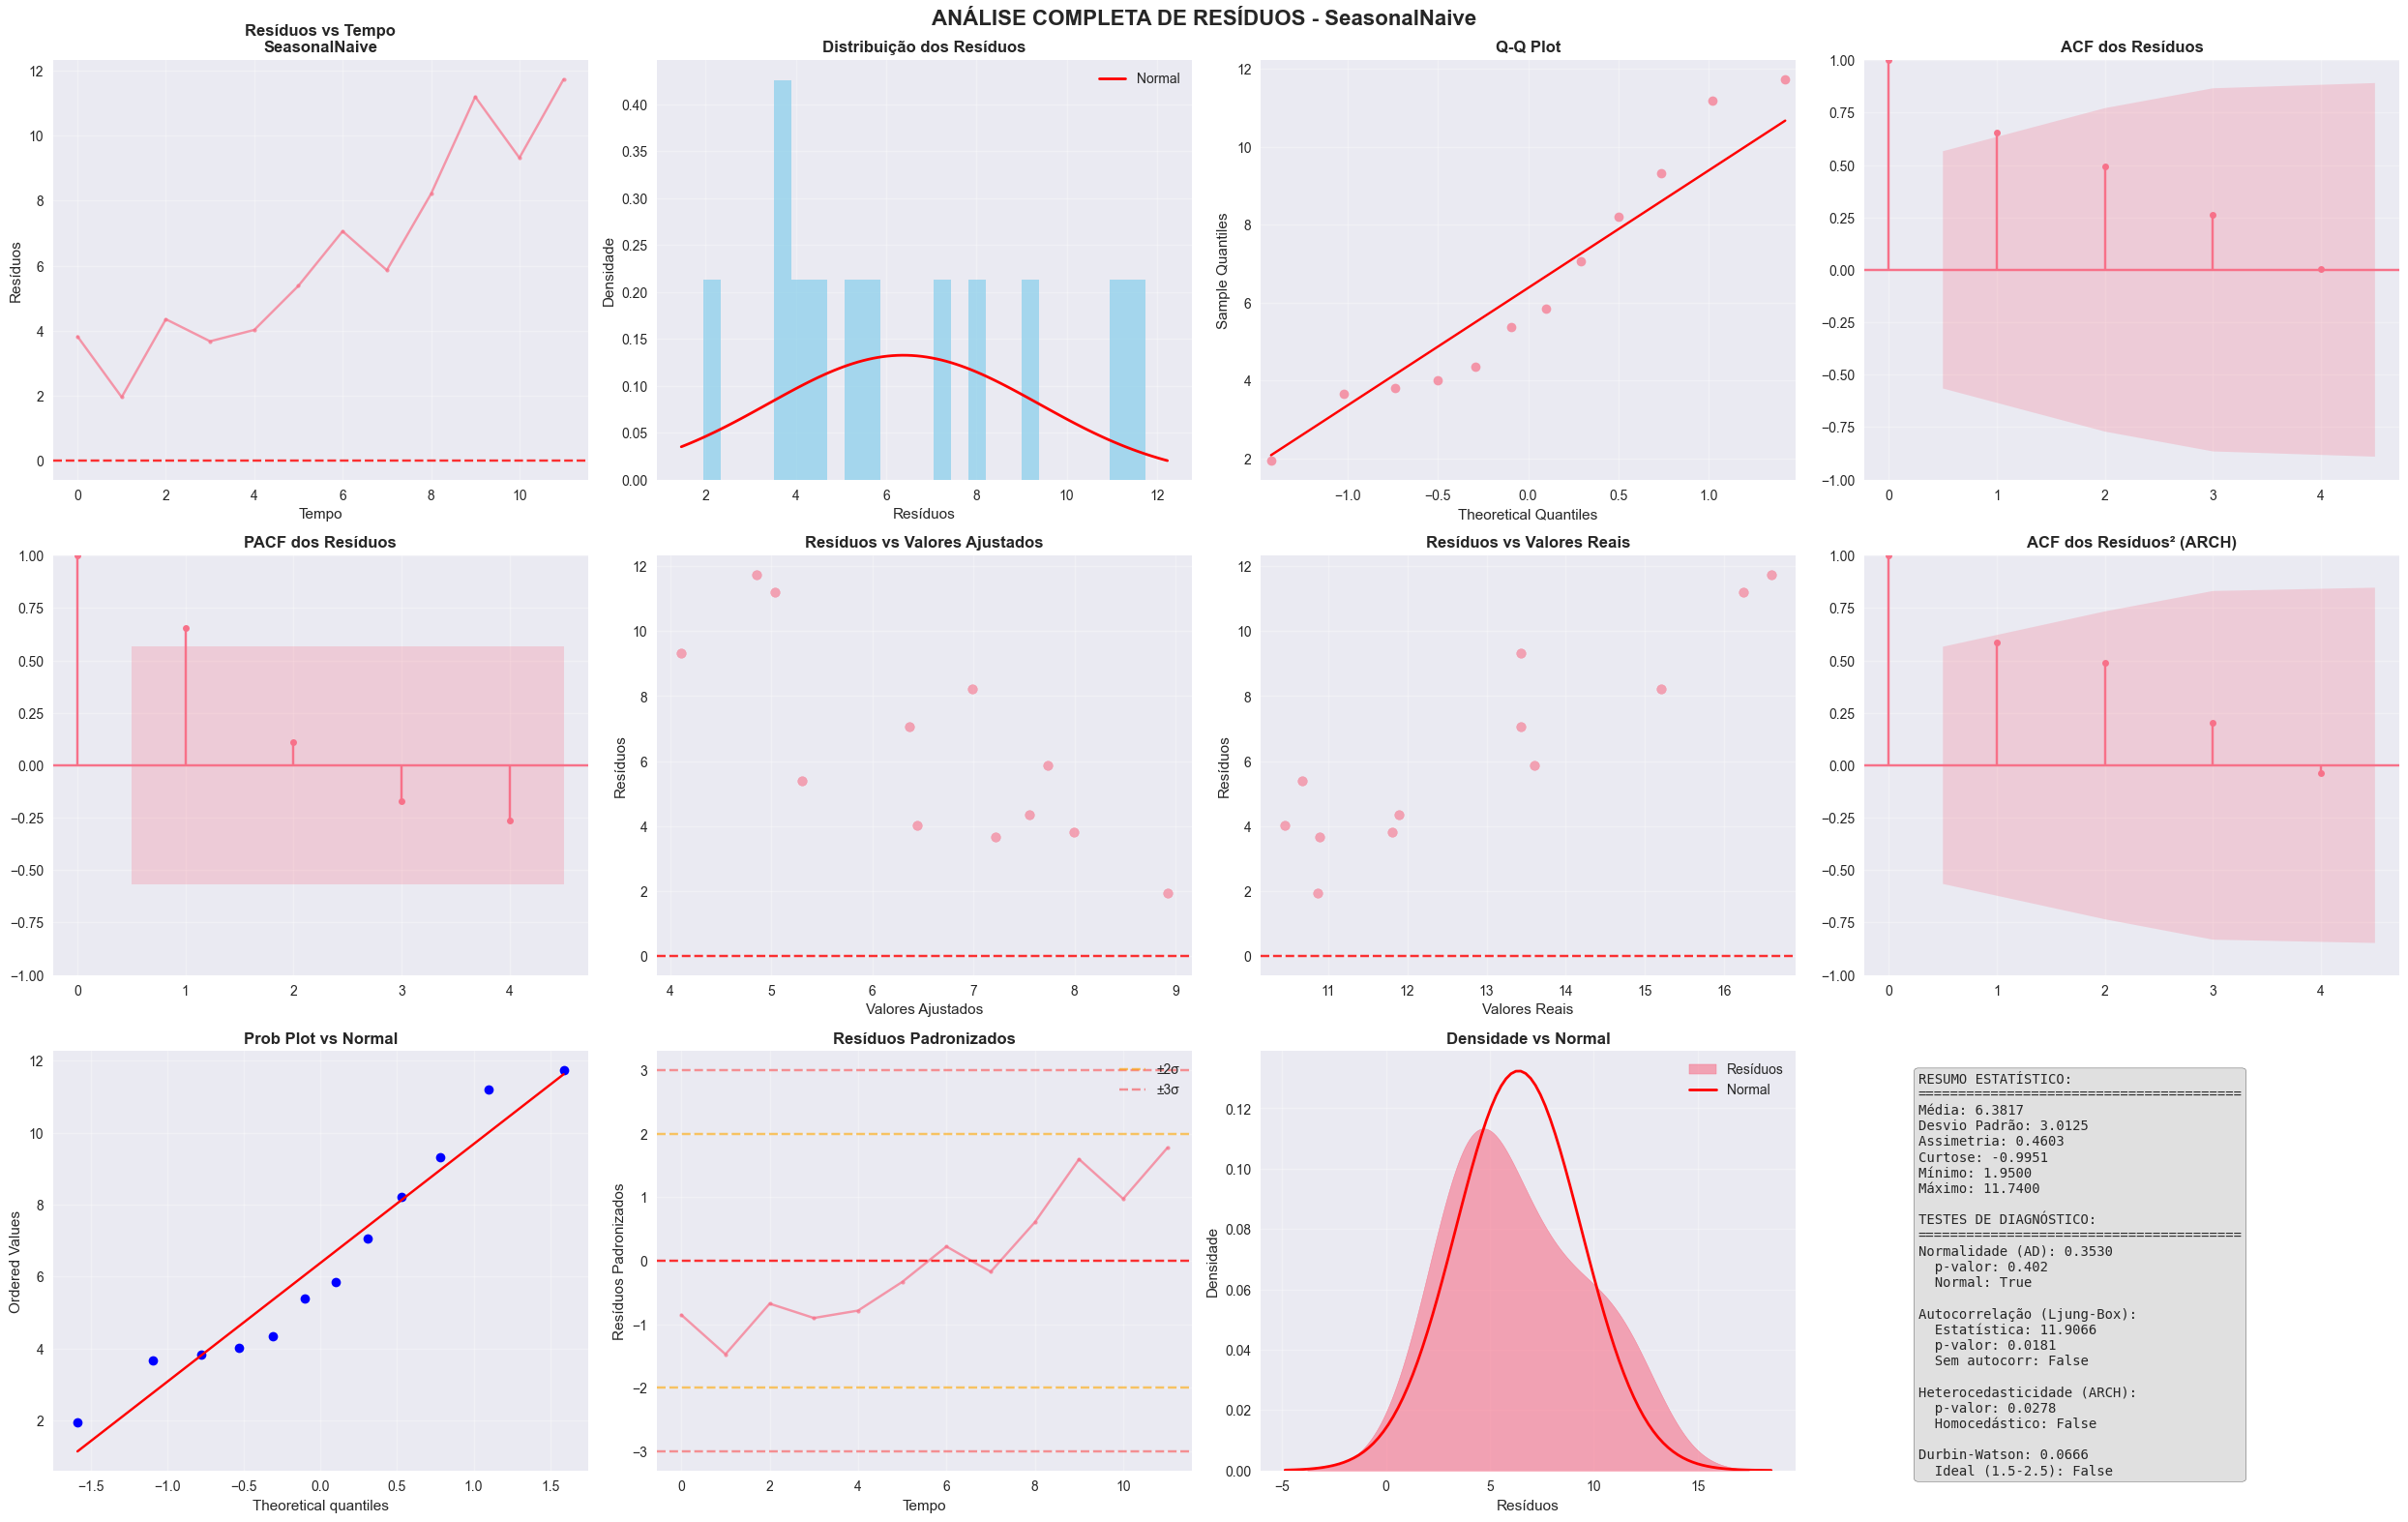


 DIAGNÓSTICO DOS RESÍDUOS:
──────────────────────────────────────────────────
X Média zero
OK Normalidade
X Sem autocorrelação
X Homocedasticidade
X Durbin-Watson

 ESTATÍSTICAS CHAVE:
   • RMSE dos resíduos: 7.0570
   • MAE dos resíduos: 6.3817
   • Assimetria: 0.4603
   • Curtose: -0.9951

 RECOMENDAÇÕES:
   • Autocorrelação detectada - modelo pode capturar padrões inadequados
   • Heterocedasticidade detectada - variância não constante
   • Autocorrelação positiva - subestimação do erro padrão

################################################################################
ANALISANDO MODELO: Drift
################################################################################
  Ajustando tamanho das previsões para Drift: 30 -> 12
 Tamanhos - Resíduos: 12, Fitted: 12, Actual: 12

ANÁLISE DE RESÍDUOS - Drift


In [ ]:
class ResidualAnalysis:
    """
    Classe completa para análise de resíduos de modelos de séries temporais
    """
    
    def __init__(self, model_name, residuals, fitted_values, actual_values, model_obj=None):
        self.model_name = model_name
        self.residuals = np.array(residuals)
        self.fitted_values = np.array(fitted_values)
        self.actual_values = np.array(actual_values)
        self.model_obj = model_obj
        self.analysis_results = {}
        
    def comprehensive_residual_analysis(self, lags=20, save_path=None):
        """
        Realiza análise completa dos resíduos
        """
        print(f"\n{'='*60}")
        print(f"ANÁLISE DE RESÍDUOS - {self.model_name}")
        print(f"{'='*60}")
        
        # 1. Testes estatísticos formais
        self._formal_tests(lags)
        
        # 2. Análise gráfica completa
        self._plot_comprehensive_analysis(lags, save_path)
        
        # 3. Diagnóstico resumido
        self._print_diagnostic_summary()
        
        return self.analysis_results
    
    def _formal_tests(self, lags):
        """Executa testes estatísticos formais nos resíduos"""
        
        # Teste de normalidade (Anderson-Darling) - CORRIGIDO
        try:
            from statsmodels.stats.diagnostic import normal_ad
            ad_stat, ad_pvalue = normal_ad(self.residuals)
            # Valores críticos para teste de Anderson-Darling (nível 5%)
            ad_critical_5percent = 0.787  # Valor crítico aproximado para 5%
            self.analysis_results['normality_ad'] = {
                'statistic': ad_stat,
                'p_value': ad_pvalue,
                'critical_5percent': ad_critical_5percent,
                'is_normal': ad_pvalue > 0.05  # p-value > 0.05 indica normalidade
            }
        except Exception as e:
            print(f"Erro no teste de normalidade: {e}")
            self.analysis_results['normality_ad'] = {
                'statistic': np.nan,
                'p_value': np.nan,
                'critical_5percent': np.nan,
                'is_normal': np.nan
            }
        
        # Teste de autocorrelação (Ljung-Box)
        try:
            lb_test = acorr_ljungbox(self.residuals, lags=[lags], return_df=True)
            self.analysis_results['ljung_box'] = {
                'statistic': lb_test['lb_stat'].iloc[0],
                'p_value': lb_test['lb_pvalue'].iloc[0],
                'no_autocorr': lb_test['lb_pvalue'].iloc[0] > 0.05
            }
        except Exception as e:
            print(f"Erro no teste Ljung-Box: {e}")
            self.analysis_results['ljung_box'] = {
                'statistic': np.nan,
                'p_value': np.nan,
                'no_autocorr': np.nan
            }
        
        # Teste de heterocedasticidade (ARCH)
        try:
            arch_test = het_arch(self.residuals)
            self.analysis_results['arch_test'] = {
                'statistic': arch_test[0],
                'p_value': arch_test[1],
                'is_homoscedastic': arch_test[1] > 0.05
            }
        except Exception as e:
            print(f"Erro no teste ARCH: {e}")
            self.analysis_results['arch_test'] = {
                'statistic': np.nan,
                'p_value': np.nan,
                'is_homoscedastic': np.nan
            }
        
        # Teste de Durbin-Watson (autocorrelação de ordem 1)
        try:
            dw_stat = durbin_watson(self.residuals)
            self.analysis_results['durbin_watson'] = {
                'statistic': dw_stat,
                'no_autocorr': 1.5 <= dw_stat <= 2.5  # Ideal entre 1.5 e 2.5
            }
        except Exception as e:
            print(f"Erro no teste Durbin-Watson: {e}")
            self.analysis_results['durbin_watson'] = {
                'statistic': np.nan,
                'no_autocorr': np.nan
            }
        
        # Estatísticas descritivas dos resíduos
        try:
            self.analysis_results['descriptive_stats'] = {
                'mean': np.mean(self.residuals),
                'std': np.std(self.residuals),
                'skewness': stats.skew(self.residuals),
                'kurtosis': stats.kurtosis(self.residuals),
                'min': np.min(self.residuals),
                'max': np.max(self.residuals)
            }
        except Exception as e:
            print(f"Erro nas estatísticas descritivas: {e}")
            self.analysis_results['descriptive_stats'] = {
                'mean': np.nan, 'std': np.nan, 'skewness': np.nan,
                'kurtosis': np.nan, 'min': np.nan, 'max': np.nan
            }
        
        # Teste se média é zero (t-test)
        try:
            t_stat, p_value = stats.ttest_1samp(self.residuals, 0)
            self.analysis_results['mean_test'] = {
                't_statistic': t_stat,
                'p_value': p_value,
                'mean_zero': p_value > 0.05
            }
        except Exception as e:
            print(f"Erro no teste de média zero: {e}")
            self.analysis_results['mean_test'] = {
                't_statistic': np.nan,
                'p_value': np.nan,
                'mean_zero': np.nan
            }
    
    def _plot_comprehensive_analysis(self, lags, save_path):
        """Gera gráficos completos de análise de resíduos"""
        
        fig = plt.figure(figsize=(25, 16))
        
        # 1. Resíduos vs Tempo
        ax1 = plt.subplot(3, 4, 1)
        plt.plot(self.residuals, 'o-', alpha=0.7, markersize=3)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.title(f'Resíduos vs Tempo\n{self.model_name}', fontsize=12, fontweight='bold')
        plt.xlabel('Tempo')
        plt.ylabel('Resíduos')
        plt.grid(True, alpha=0.3)
        
        # 2. Histograma + Distribuição Normal
        ax2 = plt.subplot(3, 4, 2)
        n, bins, patches = plt.hist(self.residuals, bins=25, density=True, alpha=0.7, color='skyblue')
        
        # Sobrepor distribuição normal
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, np.mean(self.residuals), np.std(self.residuals))
        plt.plot(x, p, 'r-', linewidth=2, label='Normal')
        plt.title('Distribuição dos Resíduos', fontsize=12, fontweight='bold')
        plt.xlabel('Resíduos')
        plt.ylabel('Densidade')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. QQ-Plot
        ax3 = plt.subplot(3, 4, 3)
        qqplot(self.residuals, line='s', ax=ax3, alpha=0.7)
        plt.title('Q-Q Plot', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 4. ACF dos Resíduos
        ax4 = plt.subplot(3, 4, 4)
        plot_acf(self.residuals, lags=lags, ax=ax4, alpha=0.05)
        plt.title('ACF dos Resíduos', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 5. PACF dos Resíduos
        ax5 = plt.subplot(3, 4, 5)
        plot_pacf(self.residuals, lags=lags, ax=ax5, alpha=0.05)
        plt.title('PACF dos Resíduos', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 6. Resíduos vs Valores Ajustados
        ax6 = plt.subplot(3, 4, 6)
        plt.scatter(self.fitted_values, self.residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.title('Resíduos vs Valores Ajustados', fontsize=12, fontweight='bold')
        plt.xlabel('Valores Ajustados')
        plt.ylabel('Resíduos')
        plt.grid(True, alpha=0.3)
        
        # 7. Resíduos vs Valores Reais
        ax7 = plt.subplot(3, 4, 7)
        plt.scatter(self.actual_values, self.residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.title('Resíduos vs Valores Reais', fontsize=12, fontweight='bold')
        plt.xlabel('Valores Reais')
        plt.ylabel('Resíduos')
        plt.grid(True, alpha=0.3)
        
        # 8. ACF dos Resíduos Quadrados (para detectar ARCH)
        ax8 = plt.subplot(3, 4, 8)
        squared_residuals = self.residuals ** 2
        plot_acf(squared_residuals, lags=lags, ax=ax8, alpha=0.05)
        plt.title('ACF dos Resíduos² (ARCH)', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 9. Distribuição Cumulativa
        ax9 = plt.subplot(3, 4, 9)
        stats.probplot(self.residuals, dist="norm", plot=ax9)
        plt.title('Prob Plot vs Normal', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 10. Resíduos Padronizados
        ax10 = plt.subplot(3, 4, 10)
        standardized_residuals = (self.residuals - np.mean(self.residuals)) / np.std(self.residuals)
        plt.plot(standardized_residuals, 'o-', alpha=0.7, markersize=3)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='±2σ')
        plt.axhline(y=-2, color='orange', linestyle='--', alpha=0.6)
        plt.axhline(y=3, color='red', linestyle='--', alpha=0.4, label='±3σ')
        plt.axhline(y=-3, color='red', linestyle='--', alpha=0.4)
        plt.title('Resíduos Padronizados', fontsize=12, fontweight='bold')
        plt.xlabel('Tempo')
        plt.ylabel('Resíduos Padronizados')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 11. Density Plot comparativo
        ax11 = plt.subplot(3, 4, 11)
        sns.kdeplot(self.residuals, fill=True, alpha=0.6, label='Resíduos')
        xmin, xmax = ax11.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        normal_pdf = stats.norm.pdf(x, np.mean(self.residuals), np.std(self.residuals))
        plt.plot(x, normal_pdf, 'r-', label='Normal', linewidth=2)
        plt.title('Densidade vs Normal', fontsize=12, fontweight='bold')
        plt.xlabel('Resíduos')
        plt.ylabel('Densidade')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 12. Resumo estatístico (texto)
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        
        stats_text = self._get_stats_text()
        ax12.text(0.1, 0.95, stats_text, transform=ax12.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
        
        plt.tight_layout()
        plt.suptitle(f'ANÁLISE COMPLETA DE RESÍDUOS - {self.model_name}', 
                    fontsize=16, fontweight='bold', y=0.9999999)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Gráfico salvo em: {save_path}")
        
        plt.show()
        
    def _get_stats_text(self):
        """Gera texto com estatísticas resumidas"""
        stats = self.analysis_results
        
        text = "RESUMO ESTATÍSTICO:\n"
        text += "="*40 + "\n"
        text += f"Média: {stats['descriptive_stats']['mean']:.4f}\n"
        text += f"Desvio Padrão: {stats['descriptive_stats']['std']:.4f}\n"
        text += f"Assimetria: {stats['descriptive_stats']['skewness']:.4f}\n"
        text += f"Curtose: {stats['descriptive_stats']['kurtosis']:.4f}\n"
        text += f"Mínimo: {stats['descriptive_stats']['min']:.4f}\n"
        text += f"Máximo: {stats['descriptive_stats']['max']:.4f}\n\n"
        
        text += "TESTES DE DIAGNÓSTICO:\n"
        text += "="*40 + "\n"
        text += f"Normalidade (AD): {stats['normality_ad']['statistic']:.4f}\n"
        text += f"  p-valor: {stats['normality_ad']['p_value']:.3f}\n"
        text += f"  Normal: {stats['normality_ad']['is_normal']}\n\n"
        
        text += f"Autocorrelação (Ljung-Box):\n"
        text += f"  Estatística: {stats['ljung_box']['statistic']:.4f}\n"
        text += f"  p-valor: {stats['ljung_box']['p_value']:.4f}\n"
        text += f"  Sem autocorr: {stats['ljung_box']['no_autocorr']}\n\n"
        
        text += f"Heterocedasticidade (ARCH):\n"
        text += f"  p-valor: {stats['arch_test']['p_value']:.4f}\n"
        text += f"  Homocedástico: {stats['arch_test']['is_homoscedastic']}\n\n"
        
        text += f"Durbin-Watson: {stats['durbin_watson']['statistic']:.4f}\n"
        text += f"  Ideal (1.5-2.5): {stats['durbin_watson']['no_autocorr']}"
        
        return text
    
    def _print_diagnostic_summary(self):
        """Imprime resumo diagnóstico no console"""
        stats = self.analysis_results
        
        print("\n DIAGNÓSTICO DOS RESÍDUOS:")
        print("─" * 50)
        
        # Verificação de pressupostos
        assumptions = {
            "Média zero": stats['mean_test']['mean_zero'] if not np.isnan(stats['mean_test']['mean_zero']) else False,
            "Normalidade": stats['normality_ad']['is_normal'] if not np.isnan(stats['normality_ad']['is_normal']) else False,
            "Sem autocorrelação": stats['ljung_box']['no_autocorr'] if not np.isnan(stats['ljung_box']['no_autocorr']) else False,
            "Homocedasticidade": stats['arch_test']['is_homoscedastic'] if not np.isnan(stats['arch_test']['is_homoscedastic']) else False,
            "Durbin-Watson": stats['durbin_watson']['no_autocorr'] if not np.isnan(stats['durbin_watson']['no_autocorr']) else False
        }
        
        for assumption, result in assumptions.items():
            status = "OK" if result else "X"
            print(f"{status} {assumption}")
        
        print(f"\n ESTATÍSTICAS CHAVE:")
        print(f"   • RMSE dos resíduos: {np.sqrt(np.mean(self.residuals**2)):.4f}")
        print(f"   • MAE dos resíduos: {np.mean(np.abs(self.residuals)):.4f}")
        print(f"   • Assimetria: {stats['descriptive_stats']['skewness']:.4f}")
        print(f"   • Curtose: {stats['descriptive_stats']['kurtosis']:.4f}")
        
        # Recomendações
        print(f"\n RECOMENDAÇÕES:")
        if not stats['normality_ad']['is_normal'] and not np.isnan(stats['normality_ad']['is_normal']):
            print("   • Resíduos não normais - considere transformação da variável")
        if not stats['ljung_box']['no_autocorr'] and not np.isnan(stats['ljung_box']['no_autocorr']):
            print("   • Autocorrelação detectada - modelo pode capturar padrões inadequados")
        if not stats['arch_test']['is_homoscedastic'] and not np.isnan(stats['arch_test']['is_homoscedastic']):
            print("   • Heterocedasticidade detectada - variância não constante")
        if stats['durbin_watson']['statistic'] < 1.5 and not np.isnan(stats['durbin_watson']['statistic']):
            print("   • Autocorrelação positiva - subestimação do erro padrão")
        elif stats['durbin_watson']['statistic'] > 2.5 and not np.isnan(stats['durbin_watson']['statistic']):
            print("   • Autocorrelação negativa - superestimação do erro padrão")

def analyze_all_models(train, test, models_predictions, actual_column='volume'):
    """
    Análise completa para todos os modelos - CORRIGIDA
    """
    results_dir = Path("./residuals_analysis")
    results_dir.mkdir(exist_ok=True)
    
    all_results = {}
    
    for model_name, predictions in models_predictions.items():
        print(f"\n{'#'*80}")
        print(f"ANALISANDO MODELO: {model_name}")
        print(f"{'#'*80}")
        
        # Pular entradas que são fitted values
        if '_fitted' in model_name:
            continue
            
        # Verificar e corrigir tamanhos incompatíveis
        predictions = np.array(predictions)
        
        # Para modelos que só têm previsões no teste
        if model_name in ['Mean', 'Naive', 'SeasonalNaive', 'Drift', 'RollingMean_k4']:
            # Usar último valor do treino como fitted para baselines simples
            fitted_values = np.repeat(train[actual_column].mean(), len(train))
            residuals_train = train[actual_column] - fitted_values
            
            # Garantir que as previsões têm o mesmo tamanho que o teste
            if len(predictions) != len(test):
                print(f"  Ajustando tamanho das previsões para {model_name}: {len(predictions)} -> {len(test)}")
                # Se há mais previsões que teste, pegar as últimas
                if len(predictions) > len(test):
                    predictions = predictions[-len(test):]
                # Se há menos previsões que teste, repetir a última
                else:
                    predictions = np.concatenate([
                        predictions, 
                        np.repeat(predictions[-1], len(test) - len(predictions))
                    ])
            
            residuals_test = test[actual_column].values - predictions
            
            # Usar resíduos do teste para análise
            residuals = residuals_test
            fitted_vals = predictions
            actual_vals = test[actual_column].values
                
        else:
            # Para modelos OLS e SARIMAX
            try:
                # Tentar obter fitted values do treino
                fitted_key = f"{model_name}_fitted"
                if fitted_key in models_predictions:
                    fitted_values = models_predictions[fitted_key]
                    residuals = train[actual_column].values - fitted_values
                    fitted_vals = fitted_values
                    actual_vals = train[actual_column].values
                else:
                    # Fallback: usar previsões do teste
                    if len(predictions) != len(test):
                        print(f"  Ajustando tamanho das previsões para {model_name}")
                        if len(predictions) > len(test):
                            predictions = predictions[-len(test):]
                        else:
                            predictions = np.concatenate([
                                predictions, 
                                np.repeat(predictions[-1], len(test) - len(predictions))
                            ])
                    
                    residuals = test[actual_column].values - predictions
                    fitted_vals = predictions
                    actual_vals = test[actual_column].values
                    
            except Exception as e:
                print(f"Erro no modelo {model_name}: {e}")
                continue
        
        print(f" Tamanhos - Resíduos: {len(residuals)}, Fitted: {len(fitted_vals)}, Actual: {len(actual_vals)}")
        
        # Verificar se temos dados suficientes para análise
        if len(residuals) < 5:
            print(f"  Modelo {model_name} ignorado - muito poucos resíduos ({len(residuals)})")
            continue
        
        # Criar análise
        analyzer = ResidualAnalysis(
            model_name=model_name,
            residuals=residuals,
            fitted_values=fitted_vals,
            actual_values=actual_vals
        )
        
        # Executar análise
        save_path = results_dir / f"residuals_analysis_{model_name.lower().replace(' ', '_')}.png"
        lags = min(10, len(residuals)//3)  # Ajustar lags baseado no tamanho dos dados
        results = analyzer.comprehensive_residual_analysis(lags=lags, save_path=save_path)
        
        all_results[model_name] = {
            'analyzer': analyzer,
            'results': results,
            'residuals': residuals
        }
    
    return all_results, results_dir

def compare_models_residuals(all_results):
    """
    Comparação entre modelos baseada na análise de resíduos
    """
    print(f"\n{'='*80}")
    print("COMPARAÇÃO ENTRE MODELOS - QUALIDADE DOS RESÍDUOS")
    print(f"{'='*80}")
    
    comparison_data = []
    
    for model_name, model_data in all_results.items():
        results = model_data['results']
        residuals = model_data['residuals']
        
        # Pontuação de qualidade (quanto maior, melhor)
        quality_score = 0
        
        # Critérios de qualidade
        criteria = {
            'Normalidade': results['normality_ad']['is_normal'] if not np.isnan(results['normality_ad']['is_normal']) else False,
            'Sem Autocorrelação': results['ljung_box']['no_autocorr'] if not np.isnan(results['ljung_box']['no_autocorr']) else False, 
            'Homocedasticidade': results['arch_test']['is_homoscedastic'] if not np.isnan(results['arch_test']['is_homoscedastic']) else False,
            'Durbin-Watson': results['durbin_watson']['no_autocorr'] if not np.isnan(results['durbin_watson']['no_autocorr']) else False,
            'Média Zero': results['mean_test']['mean_zero'] if not np.isnan(results['mean_test']['mean_zero']) else False
        }
        
        # Calcular pontuação
        for criterion, passed in criteria.items():
            if passed:
                quality_score += 1
        
        # Penalizar por variabilidade excessiva (apenas se std > 0)
        rmse_residuals = np.sqrt(np.mean(residuals**2))
        std_residuals = np.std(residuals)
        if std_residuals > 0:
            quality_score -= rmse_residuals / std_residuals
        
        comparison_data.append({
            'Modelo': model_name,
            'Qualidade_Resíduos': quality_score,
            'RMSE_Resíduos': rmse_residuals,
            'Normalidade': 'OK' if criteria['Normalidade'] else 'X',
            'Autocorrelação': 'OK' if criteria['Sem Autocorrelação'] else 'X',
            'Homocedasticidade': 'OK' if criteria['Homocedasticidade'] else 'X',
            'Durbin_Watson': 'OK' if criteria['Durbin-Watson'] else 'X',
            'Média_Zero': 'OK' if criteria['Média Zero'] else 'X'
        })
    
    # Criar DataFrame de comparação
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Qualidade_Resíduos', ascending=False)
    
    print("\n🏆 RANKING DE MODELOS POR QUALIDADE DOS RESÍDUOS:")
    print(comparison_df.to_string(index=False))
    
    # Plot comparativo
    if len(comparison_df) > 0:
        plt.figure(figsize=(12, 8))
        
        # Gráfico de barras da qualidade
        plt.subplot(2, 1, 1)
        models = comparison_df['Modelo']
        scores = comparison_df['Qualidade_Resíduos']
        
        colors = ['green' if x == max(scores) else 'blue' for x in scores]
        bars = plt.bar(range(len(models)), scores, color=colors)
        plt.ylabel('Pontuação de Qualidade')
        plt.title('Comparação da Qualidade dos Resíduos entre Modelos', fontweight='bold')
        plt.xticks(range(len(models)), models, rotation=45, ha='right')
        
        # Adicionar valores nas barras
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{score:.1f}', ha='center', va='bottom')
        
        # Gráfico de RMSE dos resíduos
        plt.subplot(2, 1, 2)
        rmse_values = comparison_df['RMSE_Resíduos']
        bars = plt.bar(range(len(models)), rmse_values, color='red', alpha=0.7)
        plt.ylabel('RMSE dos Resíduos')
        plt.title('RMSE dos Resíduos por Modelo', fontweight='bold')
        plt.xticks(range(len(models)), models, rotation=45, ha='right')
        
        # Adicionar valores nas barras
        for bar, rmse in zip(bars, rmse_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{rmse:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    return comparison_df


def run_complete_residual_analysis():
    """
    Executa análise completa de resíduos para todos os modelos implementados - CORRIGIDA
    """
    
    print(" INICIANDO ANÁLISE DE RESÍDUOS...")
    
    # Verificar se as variáveis necessárias existem
    required_vars = ['train', 'test', 'mean_pred', 'naive_pred', 'drift_pred', 'rolling_mean_pred', 'reg_pred', 'sarimax_pred_mean']
    
    missing_vars = [var for var in required_vars if var not in globals()]
    if missing_vars:
        print(f"  Variáveis faltantes: {missing_vars}")
        print("   Execute primeiro a análise completa dos modelos")
        return None, None, None
    
    # Criar dicionário com todas as previsões
    models_predictions = {}
    
    # Adicionar baselines
    models_predictions['Mean'] = mean_pred
    models_predictions['Naive'] = naive_pred
    if 'seasonal_naive_pred' in globals():
        models_predictions['SeasonalNaive'] = seasonal_naive_pred
    models_predictions['Drift'] = drift_pred
    models_predictions['RollingMean_k4'] = rolling_mean_pred
    
    # Adicionar modelos avançados
    models_predictions['Regression'] = reg_pred.values if hasattr(reg_pred, 'values') else reg_pred
    models_predictions['SARIMAX'] = sarimax_pred_mean.values if hasattr(sarimax_pred_mean, 'values') else sarimax_pred_mean
    
    # Para modelos OLS e SARIMAX, também precisamos dos fitted values no treino
    try:
        if 'ols_train' in globals():
            models_predictions['Regression_fitted'] = ols_train.fittedvalues
        if 'best_res' in globals():
            models_predictions['SARIMAX_fitted'] = best_res.fittedvalues
    except Exception as e:
        print(f"Aviso: Não foi possível obter fitted values: {e}")
    
    # Verificar tamanhos
    print("\n VERIFICAÇÃO DE TAMANHOS:")
    for model_name, preds in models_predictions.items():
        if '_fitted' not in model_name:
            print(f"   {model_name}: {len(preds)} previsões")
    
    print(f"   Teste: {len(test)} observações")
    print(f"   Treino: {len(train)} observações")
    
    # Executar análise completa
    all_results, results_dir = analyze_all_models(
        train, 
        test, 
        models_predictions, 
        actual_column='volume'
    )
    
    if not all_results:
        print(" Nenhum modelo pôde ser analisado")
        return None, None, None
    
    # Comparação entre modelos
    comparison_df = compare_models_residuals(all_results)
    
    # Salvar resultados detalhados
    detailed_results = {}
    for model_name, model_data in all_results.items():
        detailed_results[model_name] = model_data['results']
    
    # Converter para DataFrame e salvar
    results_list = []
    for model_name, results in detailed_results.items():
        row = {'Modelo': model_name}
        for test_name, test_results in results.items():
            if isinstance(test_results, dict):
                for key, value in test_results.items():
                    if isinstance(value, (int, float)):
                        row[f"{test_name}_{key}"] = value
                    elif isinstance(value, bool):
                        row[f"{test_name}_{key}"] = value
            else:
                row[test_name] = test_results
        results_list.append(row)
    
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_dir / "detailed_residuals_analysis.csv", index=False)
    
    print(f"\n Todos os resultados salvos em: {results_dir}")
    
    return all_results, comparison_df, results_df

# Execute a análise completa
print(" EXECUTANDO ANÁLISE DE RESÍDUOS...")
all_results, comparison_df, detailed_results = run_complete_residual_analysis()

if all_results is not None:
    # Acesse resultados específicos
    best_model = comparison_df.iloc[0]['Modelo']
    print(f"\n MELHOR MODELO: {best_model}")
    
    # Veja detalhes de um modelo específico
    if 'Regression' in all_results:
        ols_results = all_results['Regression']['results']
        print(f" Normalidade OLS: {ols_results['normality_ad']['is_normal']}")
else:
    print(" Análise não pôde ser completada. Verifique se todos os modelos foram executados.")